Dicionarios de dados:
https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/pdfs/dicionario_de_dados_srag_hosp_17_02_2022.pdf

In [ ]:
from google.colab import drive                                                                                                                                                                                               #1
drive.mount('/content/drive')

Mounted at /content/drive


# Funções e imports

In [ ]:
import pandas as pd                                                                                                                                                                                                          #2
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
def grafico_barra(serie,title=None,ylabel=None,xlabel=None,legend = None,color='b', show = True):                                                                                                                            #3
    plt.figure(figsize=(20, 4)) 
    plt.bar(np.arange(0,serie.size), serie, color = color,
            label=legend)

    if title : plt.title( title)
    if ylabel: plt.ylabel(ylabel)
    if xlabel: plt.xlabel(xlabel)
    if legend: plt.legend()
    if show: plt.show()

In [ ]:
def plot_por_dia(filtrado, Npessoas_dia, titulo = '' , titulo_taxa = '', contagem = True, taxa = True,color = 'blue',show = True,return_distributions = True):
    filtrado_por_dia = filtrado_taxa = None

    if contagem:
        filtrado_por_dia = filtrado[["DIA_PRI","DT_NOTIFIC"]].groupby(by="DIA_PRI").count() 
        filtrado_por_dia = filtrado_por_dia.rename(columns={"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame() 



        plt.figure(figsize=(20, 4));
        plt.bar(filtrado_por_dia.index,filtrado_por_dia.N_pessoas,color = color,)
        if show: 
            plt.title("N° "+ titulo)
            
            plt.legend()
            plt.show()


    if taxa:
        filtrado_taxa = filtrado_por_dia/(Npessoas_dia.to_frame())
        plt.figure(figsize=(20, 4))
        plt.bar(filtrado_taxa.index,filtrado_taxa.N_pessoas,color = color,width=0.4,)
        if show:
            plt.title("TAXA " + titulo_taxa)
            plt.legend()
            plt.show()
    if return_distributions:
        return filtrado_por_dia, filtrado_taxa

In [ ]:
def plot_por_idade(filtrado, Npessoas_idade, titulo = '' , titulo_taxa = '', contagem = True, taxa = True,color = 'blue',show = True,return_distributions = True):
    
    filtrado_por_idade = filtrado_taxa = None

    filtrado_por_idade = filtrado[["NU_IDADE_N","DT_NOTIFIC"]].groupby(by="NU_IDADE_N").count() 
    filtrado_por_idade = filtrado_por_idade.rename(columns={"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame() 

    if contagem:

        plt.figure(figsize=(20, 4));
        plt.bar(filtrado_por_idade.index,filtrado_por_idade.N_pessoas,color = color,)
        if show:
            media_idade = round( filtrado.NU_IDADE_N.mean() , 2)
            std_idade   = round( filtrado.NU_IDADE_N.std()  , 2)
            print(f'Média de idade: {media_idade}')
            print(f'Desvio padrão da idade: {std_idade}')     
            print(f"idades dentro de 1 desvio padrão:   [{media_idade-std_idade}, {media_idade+std_idade}]")
            print(f"idades dentro de 2 desvios padrões: [{media_idade-2*std_idade}, {media_idade+2*std_idade}]")

            plt.title("N° "+ titulo)
            plt.ylabel("N° pessoas")
            plt.xlabel("idade")
            
            plt.show()


    if taxa:
        filtrado_taxa = filtrado_por_idade/Npessoas_idade
        plt.figure(figsize=(20, 4))
        plt.bar(filtrado_taxa.index,filtrado_taxa.N_pessoas,color = color,width=0.4,)
        if show:
               
            plt.title("TAXA " + titulo_taxa)
            
            plt.show()


    print("\n\n")
    if return_distributions:
        return filtrado_por_idade, filtrado_taxa

In [ ]:
def multi_plot(distribuicoes, N_pessoas_idade,titulo = "", labels=['']*3 , titulo_taxa = ['']*3, contagem = True, taxa = False,colors = None,show = True):

       
    plt.figure(figsize=(20, 4)) 
    N = len(distribuicoes)
    if N != 2 and N!=3:  print("apenas 2 ou 3 distribuicoes por vez"); return None
    
    if colors is None: colors = ["red","green","blue"]

    if N == 2: offsets = [-0.3, 0     ]
    if N == 3: offsets = [-0.3, 0, 0.3]

    for distribuicao ,offset,color,label in zip(distribuicoes,offsets,colors,labels):
        plt.bar(
                np.arange(0,distribuicao.N_pessoas.size)+offset,
                distribuicao.N_pessoas,
                color = color,
                label = label,
                width=0.4
                )
    


    plt.title(titulo)
    plt.legend()
    plt.show()
    

In [ ]:
def print_range(df):                                                                                                                                                                                                         #4
    print(pd.to_datetime(df["DT_NOTIFIC"]).min(), pd.to_datetime(df["DT_NOTIFIC"]).max())

# Unir bases de dados

Colunas selecionadas:

* 1 - Idade [x]
* 2 - Fatores de risco [x] 
* 3 - Fatores de risco/ Doença Cardiovascular Crônica [x]
* 4 - Fatores de risco/ Asma [x]
* 5 - Pneumatopatia Crônica [x]
* 6 - Fatores de risco/ Diabetes mellitus [x]
* 7 - Fatores de risco/ Imunodeficiência ou Imunodepressão [x]
* 8 - Fatores de risco/ Obesidade [x]
* 9 - Fatores de risco/ Obesidade(Descrição IMC) [x]
* 10 - Recebeu a vacina COVID-19? [x]
* 11 - Recebeu vacina contra Gripe na última campanha? 
* 12 - Houve internação? [x]
* 13 - colunas com as datas referentes a cada um dos eventos  temporais 
* 14 - Internado em UTI? [x]
* 15 - Uso de suporte ventilatório?
* 16 - Agente etiológico – Teste Antigênico.
* 17 - SARS-CoV-2
* 18 - Aspecto Tomografia
* 19 - Resultado da RT-PCR/outro método por Biologia Molecular
* 20 - Agente etiológico – RT-PCR/outro método por Biologia Molecular: SARS-CoV-2 
* 21 - Agente etiológico – Teste Antigênico. Positivo para Influenza? 
* 22 - Resultado do Teste Antigênico
* 23 - Resultado do Teste Sorológico para SARS-CoV-2: IgG
* 24 - Resultado do Teste Sorológico para SARS-CoV-2: IgM 
* 25 - Resultado do Teste Sorológico para SARS-CoV-2: IgA 
* 26-   data primeiros sintomas


In [ ]:
colunas_selecionadas = [                                                                                                                                                                                                       #5
    "NU_IDADE_N",
    "FATOR_RISC",   # fatores de risco    
    "CARDIOPATI",   # fatores de risco  
    "ASMA",         # fatores de risco 
    "PNEUMOPATI",   # fatores de risco         
    "DIABETES",     # fatores de risco       
    "IMUNODEPRE",   # fatores de risco         
    "OBESIDADE",    # fatores de risco        
    "OBES_IMC",     # fatores de risco       
    "VACINA_COV",   # vacina    
    "VACINA",       # vacina       
    "DT_SIN_PRI",   # datas    
    "DT_NOTIFIC",   # datas    
    "DT_NASC",      # datas 
    "DOSE_1_COV",   # datas    
    "DOSE_2_COV" ,  # datas    
    "DOSE_REF",     # datas 
    "DT_UT_DOSE",   # datas   
    "DT_INTERNA",   # datas   
    "DT_ENTUTI",    # datas  
    "DT_SAIDUTI",   # datas 
    "DT_EVOLUCA",   # datas    
    "UTI",
    "HOSPITAL",     # nao faz sentido , a base so deveria possuir internados       
    "EVOLUCAO",     
    "CLASSI_FIN",       
    "TOMO_RES",     
    "RES_AN",     
    "PCR_RESUL",     
    "PCR_SARS2",     
    "POS_AN_FLU",     
    "RES_IGG",     
    "RES_IGM",     
    "RES_IGA",     
    "SEM_NOT", #Semana Epidemiológica do preenchimento da ficha de notificação
    "SEM_PRI",  #Semana Epidemiológica dos Primeiros Sintomas
    
]

## Compatibilidade entre as bases


Podemos ver que a base de dados de 2020 não possui todas as colunas que as outras. Em especial , as colunas selecionadas: 'VACINA_COV' (se o paciente recebeu a vacina do covid), 'DOSE_1_COV' (data em que recebeu a 1° dose), 'DOSE_2_COV' (data em que recebeu a 2° dose), 'DOSE_REF' (data em que recebeu a dose de reforço).

As datas referentes a vacina na base de 2020 não informam claramente se é para gripe ou covid.

Pela data, sabemos que a maioria das pessoas não tomou a vacina. 

Apenas cerca de 5% da base de dados de 2020 (estranhamente) está depois de 17/01/2021 (início da vacinação do brasil), e pôde ser vacinada. Portanto, não teremos problemas em considerar que ninguem foi vacinado nesta base.

In [ ]:
df20 = pd.read_csv('/content/drive/MyDrive/BasesSUS/base-2020.csv',error_bad_lines=False,sep = ';')                                                                                                                          #6
print("\ninformações")
df20.info()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,59,61,62,63,91,93,105,114,116,117,118,122) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)



informações
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199992 entries, 0 to 1199991
Columns: 153 entries, DT_NOTIFIC to RES_IGA
dtypes: float64(87), int64(9), object(57)
memory usage: 1.4+ GB


In [ ]:
for col_escolhida in [ 'DOSE_1_COV' , 'DOSE_2_COV' , 'DOSE_REF']:                                                                                                                       #7
    print(col_escolhida,end = " ")
    if col_escolhida in df20.columns: print("está na base de 2020")
    else:
        print("não está na base de 2020")
        df20[col_escolhida] = np.NaN

DOSE_1_COV não está na base de 2020
DOSE_2_COV não está na base de 2020
DOSE_REF não está na base de 2020


Se está em 2020, não tomou a vacina.

In [ ]:
df20["VACINA_COV"] = 2

In [ ]:
print("primeira e última datas:")                                                                                                                                                                                            #8
print_range(df20)
print("\npessoas que notificaram depois de 17/01/2021:",end=" ")
depois20 = df20[pd.to_datetime(df20["DT_NOTIFIC"]) > pd.to_datetime("31/12/2020",dayfirst = True)].shape[0]
print(depois20)
total20 = df20.shape[0]
print("tamanho total da base:                      ", total20,)
print("% de pessoas que notificaram depois de 2020:",round(100*depois20/total20,2))

primeira e última datas:
2019-12-29 00:00:00 2022-12-03 00:00:00

pessoas que notificaram depois de 17/01/2021: 57518
tamanho total da base:                       1199992
% de pessoas que notificaram depois de 2020: 4.79


Filtrando colunas de interesse na base de 2020

In [ ]:
df20 = df20[colunas_selecionadas]                                                                                                                                                                                            #9

## Unir as bases

In [ ]:
df21 = pd.read_csv('/content/drive/MyDrive/BasesSUS/base-2021.csv',error_bad_lines=False,sep = ';')                                                                                                                         #10
print("-"*100)
print("df21")
print_range(df21)
df21 = df21[colunas_selecionadas]
df = df20.append(df21, ignore_index=True)

# liberar memória
del df20
del df21

print("-"*100)


df22 = pd.read_csv('/content/drive/MyDrive/BasesSUS/base-2022.csv',error_bad_lines=False,sep = ';')
print("-"*100)
print("df22")
print_range(df22)
df22 = df22[colunas_selecionadas]



df = df  .append(df22,ignore_index = True)
print("-"*100)

del df22

print("df")
print_range(df)

print("-"*100)
print(df.info())
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,59,61,62,63,91,93,105,107,114,116,117,118,122,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


----------------------------------------------------------------------------------------------------
df21
2021-01-02 00:00:00 2022-12-03 00:00:00
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (15,59,61,62,63,66,91,93,107,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


----------------------------------------------------------------------------------------------------
df22
2022-01-02 00:00:00 2022-12-03 00:00:00
----------------------------------------------------------------------------------------------------
df
2019-12-29 00:00:00 2022-12-03 00:00:00
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107773 entries, 0 to 3107772
Data columns (total 36 columns):
 #   Column      Dtype  
---  ------      -----  
 0   NU_IDADE_N  int64  
 1   FATOR_RISC  object 
 2   CARDIOPATI  float64
 3   ASMA        float64
 4   PNEUMOPATI  float64
 5   DIABETES    float64
 6   IMUNODEPRE  float64
 7   OBESIDADE   float64
 8   OBES_IMC    object 
 9   VACINA_COV  float64
 10  VACINA      float64
 11  DT_SIN_PRI  object 
 12  DT_NOTIFIC  object 
 13  DT_NASC     object 
 14  DOSE_1_COV  object 
 15  DOSE_2_COV  object 
 16  DOSE_REF    object 
 17  DT_UT_DOSE  obje

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,TOMO_RES,RES_AN,PCR_RESUL,PCR_SARS2,POS_AN_FLU,RES_IGG,RES_IGM,RES_IGA,SEM_NOT,SEM_PRI
0,7,S,NaN,NaN,1.0,NaN,1.0,NaN,NaN,2.0,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2,2
1,1,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
2,57,S,1.0,2.0,2.0,1.0,2.0,2.0,NaN,2.0,...,NaN,5.0,2.0,NaN,NaN,NaN,NaN,NaN,7,6
3,9,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,4.0,1.0,NaN,NaN,NaN,NaN,NaN,5,5
4,1,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,5.0,1.0,NaN,NaN,NaN,NaN,NaN,3,2


# Completando informações

1. se foi para uti  ---->  foi internado 
2. se tomou alguma dose   ----> VACINA_COV == 1



In [ ]:
print("N° de não internados na UTI:",df[["HOSPITAL","UTI"]][(df.HOSPITAL == 2) & (df.UTI == 1)].shape[0])

N° de não internados na UTI: 0


In [ ]:
tomou_alguma =  (pd.isnull(df.DOSE_1_COV) == False ) |(pd.isnull(df.DOSE_2_COV) == False ) | (pd.isnull(df.DOSE_REF) == False )
df_vacina_nao_reg = df[ tomou_alguma][ (pd.isnull(df.VACINA_COV)) | (df.VACINA_COV == 2) | ( df.VACINA_COV == 9) ] # vacina nao preenchida

print("vacinados sem campo de vacinação")
df_vacina_nao_reg[["DOSE_1_COV","DOSE_2_COV","DOSE_REF", "VACINA_COV","NU_IDADE_N","EVOLUCAO","CLASSI_FIN"]]

vacinados sem campo de vacinação


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,DOSE_1_COV,DOSE_2_COV,DOSE_REF,VACINA_COV,NU_IDADE_N,EVOLUCAO,CLASSI_FIN
1201166,25/03/2021,23/04/2021,NaN,NaN,69,1.0,5.0
1201268,09/02/2021,07/03/2021,NaN,NaN,83,2.0,4.0
1202844,08/03/2021,01/04/2021,NaN,2.0,79,2.0,4.0
1202849,23/05/2021,NaN,NaN,2.0,73,1.0,4.0
1203954,18/03/2021,11/04/2021,NaN,9.0,73,1.0,4.0
...,...,...,...,...,...,...,...
3099111,08/03/2021,13/04/2021,NaN,9.0,81,2.0,5.0
3101893,07/12/2021,29/03/2021,19/05/2021,2.0,54,1.0,5.0
3102381,08/10/2021,09/11/2021,NaN,9.0,13,1.0,4.0
3105319,23/09/2021,02/12/2021,NaN,2.0,18,2.0,5.0


Consertando o campo de vacina para covid:

* Se tem data registrada: 
(pd.isnull(df.DOSE_1_COV) == False ) | (pd.isnull(df.DOSE_2_COV) == False ) | (pd.isnull(df.DOSE_REF) == False) -------> vacina_cov = 1
* Se não tem e o valor for NaN no campo da vacina_cov --------> vacina_cov= 9
* Se não tem e o valor for 2 ou 9 no campo da vacina ---------> vacina_cov = vacina_cov

Fórmula para preencher coluna vacina_cov

In [ ]:
(
            (( pd.isnull(df["DOSE_1_COV"]) == False ) | (pd.isnull(df["DOSE_2_COV"]) == False ) | (pd.isnull(df["DOSE_REF"]) == False )  | (df["VACINA_COV"] == 1))*1
   +        (( pd.isnull(df["DOSE_1_COV"]) ) &  (pd.isnull(df["DOSE_2_COV"])) & (pd.isnull(df["DOSE_REF"])) & (  (pd.isnull(df["VACINA_COV"])) | (df["VACINA_COV"] == 9)  )   )*9    
   +        (( pd.isnull(df["DOSE_1_COV"]) ) &  (pd.isnull(df["DOSE_2_COV"])) & (pd.isnull(df["DOSE_REF"])) & (pd.isnull(df["VACINA_COV"]) == False ) & (df["VACINA_COV"] == 2))*2   
).to_frame().drop_duplicates()

,0
0,2
1199992,9
1200011,1


In [ ]:
df["VACINA_COV"] =  (( pd.isnull(df["DOSE_1_COV"]) == False ) | (pd.isnull(df["DOSE_2_COV"]) == False ) | (pd.isnull(df["DOSE_REF"]) == False )  | (df["VACINA_COV"] == 1))*1+ (( pd.isnull(df["DOSE_1_COV"]) ) &  (pd.isnull(df["DOSE_2_COV"])) & (pd.isnull(df["DOSE_REF"])) & (  (pd.isnull(df["VACINA_COV"])) | (df["VACINA_COV"] == 9)  )   )*9    + (( pd.isnull(df["DOSE_1_COV"]) ) &  (pd.isnull(df["DOSE_2_COV"])) & (pd.isnull(df["DOSE_REF"])) & (pd.isnull(df["VACINA_COV"]) == False ) & (df["VACINA_COV"] == 2))*2   

In [ ]:
print("após o preenchimento temos apenas os três valores nos campos:\n",df["VACINA_COV"].drop_duplicates())

após o preenchimento temos apenas os três valores nos campos:
 0          2
1199992    9
1200011    1
Name: VACINA_COV, dtype: int64


# Eliminando datas absurdas (hoje dia 24/03/2022)

## Para realizar comparações temporais entre datas será necessário fazer o casting das colunas para datetime, caso contrário, a comparação se dará pela ordem alfabética nas quais os números aparecem.


### Tratando datas NaN

Interpretamos que uma data NaN pode signifcar:


1.   A data não foi registrada
2.   O paciente não fez a atividade relacionada àquela data. Exemplo: o paciente não precisou ir para UTI, portanto seu campo DT_ENTUTI (data de entrada na UTI) está correto.



In [ ]:
cols_datas_erradas = ["DOSE_1_COV","DOSE_2_COV","DT_ENTUTI","DT_INTERNA"]

#### Datas erradas e casting para datetime

#### Transformando em datetime

In [ ]:
df_dt_erro = pd.DataFrame()

In [ ]:
for col in cols_datas_erradas:
  print("_"*25,"\n")
  print(col)
  nome_col_ano = "ANO_" + col
  df[nome_col_ano] = df[col].str.split('/').str[2]  # pega ano

  print("N° de NaN:",df[nome_col_ano][pd.isnull(df[nome_col_ano]) == True].shape[0]) 
  
  # Convertendo casos com datas corretas 
  correto = df[nome_col_ano][pd.isnull(df[nome_col_ano]) == False].between('2020','2022')
  
  errado =     correto == False   # pegar os errados
  df_dt_erro_especifico = df[pd.isnull(df[nome_col_ano]) == False][errado]
  df_dt_erro = df_dt_erro.append(df_dt_erro_especifico, ignore_index=True) 

  df[col] = pd.to_datetime(df[col][pd.isnull(df[nome_col_ano]) == False][correto],dayfirst = True)
  print(df_dt_erro_especifico[col].loc[:])
  print()

_________________________ 

DOSE_1_COV
N° de NaN: 2694808
1218029    30/04/8202
1234467    26/05/2121
1237383    27/05/1921
1247183    07/03/2011
1257610    28/02/8202
              ...    
3052452    22/01/2202
3062305    03/03/3021
3079103    01/03/2032
3082864    10/09/2023
3105819    25/01/3021
Name: DOSE_1_COV, Length: 118, dtype: object

_________________________ 

DOSE_2_COV
N° de NaN: 2817445
1203560    06/04/2002
1243096    25/04/2201
1264331    13/05/4202
1279295    24/04/2024
1298811    29/04/2029
              ...    
3083370    27/04/2121
3088151    27/04/2027
3091200    24/05/5202
3095575    08/07/2121
3100094    03/12/2011
Name: DOSE_2_COV, Length: 134, dtype: object

_________________________ 

DT_ENTUTI
N° de NaN: 2236404
57001      27/11/2019
70776      05/11/2019
107930     30/12/2019
115788     18/07/2019
145458     29/12/2019
213241     30/12/2019
269194     29/12/2019
309104     05/12/2019
398547     30/12/2019
487835     19/11/2929
506178     02/08/2220
520433   

In [ ]:
datas = [
    "DT_SIN_PRI",
    "DT_NOTIFIC",
    "DOSE_1_COV",
    "DOSE_2_COV" ,
    "DOSE_REF",
    "DT_UT_DOSE",
    "DT_INTERNA",
    "DT_ENTUTI",
    "DT_SAIDUTI",
    "DT_EVOLUCA",
    "DT_NASC"
    ]

In [ ]:
df.DT_SIN_PRI   = pd.to_datetime(df.DT_SIN_PRI,dayfirst = True)
df.DT_NOTIFIC   = pd.to_datetime(df.DT_NOTIFIC,dayfirst = True)
df.DT_NASC      = pd.to_datetime(df.DT_NASC   ,dayfirst = True)
#df.DOSE_1_COV   = pd.to_datetime(df.DOSE_1_COV,dayfirst = True)
#df.DOSE_2_COV   = pd.to_datetime(df.DOSE_2_COV,dayfirst = True)
df.DOSE_REF     = pd.to_datetime(df.DOSE_REF  ,dayfirst = True)
df.DT_UT_DOSE   = pd.to_datetime(df.DT_UT_DOSE,dayfirst = True)
#df.DT_INTERNA   = pd.to_datetime(df.DT_INTERNA,dayfirst = True) 
#df.DT_ENTUTI    = pd.to_datetime(df.DT_ENTUTI ,dayfirst = True) 
df.DT_SAIDUTI   = pd.to_datetime(df.DT_SAIDUTI,dayfirst = True)
df.DT_EVOLUCA   = pd.to_datetime(df.DT_EVOLUCA,dayfirst = True)


In [ ]:
DATA_MAXIMA = pd.to_datetime("24/03/2022",dayfirst = True)
DATA_MINIMA =  pd.to_datetime('01/01/2020',dayfirst = True)

In [ ]:
for data in datas:
    df_futuro = df[[data,"NU_IDADE_N"]][ df[data] > pd.to_datetime("24/03/2022",dayfirst = True)].sort_values(by = data)
    print(df[[data,"NU_IDADE_N"]][ df[data] > DATA_MAXIMA].sort_values(by = data))
    df_dt_erro = df_dt_erro.append(df_futuro,ignore_index = True)
    

Empty DataFrame
Columns: [DT_SIN_PRI, NU_IDADE_N]
Index: []
Empty DataFrame
Columns: [DT_NOTIFIC, NU_IDADE_N]
Index: []
        DOSE_1_COV  NU_IDADE_N
3041417 2022-03-25          78
3074534 2022-03-25          80
2938662 2022-03-25          70
3049517 2022-03-25          80
3038175 2022-03-25          71
...            ...         ...
2258775 2022-11-16          52
3007568 2022-11-25          33
3087279 2022-12-01          72
3029846 2022-12-08          15
3039870 2022-12-10          21

[280 rows x 2 columns]
        DOSE_2_COV  NU_IDADE_N
2968812 2022-03-25          87
3001499 2022-03-25          81
2924530 2022-03-25          80
3021573 2022-03-26          85
3003890 2022-03-26          73
...            ...         ...
3021227 2022-12-09          87
2942688 2022-12-17          44
3050355 2022-12-20          14
3031290 2022-12-21          80
3093669 2022-12-31          75

[442 rows x 2 columns]
          DOSE_REF  NU_IDADE_N
3030179 2022-04-12          51
2026350 2022-06-21        

In [ ]:
# nao remover datas de nascimento abaixo do limite inferior
for data in datas[:-1]:
    print(data)

    print("datas absurdas: \n",df[(df[data] > DATA_MAXIMA) | (df[data] < DATA_MINIMA)][data])

    fora_do_intervalo_limite_superior = df.index[(df[data] > DATA_MAXIMA)]
    df_dt_erro.append(df.loc[fora_do_intervalo_limite_superior],ignore_index = True)
    df.drop(index = fora_do_intervalo_limite_superior, inplace = True)

    fora_do_intervalo_limite_inferior = df.index[(df[data] < DATA_MINIMA)]
    df_dt_erro.append(df.loc[fora_do_intervalo_limite_inferior],ignore_index = True)
    df.drop(index = fora_do_intervalo_limite_inferior, inplace = True)

    print(
    "N° datas absurdas após limpeza: \n",
    df[(df[data] > DATA_MAXIMA) | (df[data] < DATA_MINIMA)][data].shape[0]
    )
    print("-"*30)

data = datas[-1]
print(data)
print("datas absurdas: \n",df[df[data] > DATA_MAXIMA ][data])
fora_do_intervalo_limite_superior = df.index[(df[data] > DATA_MAXIMA)]
df_dt_erro.append(df.loc[fora_do_intervalo_limite_superior],ignore_index = True)
df.drop(index = fora_do_intervalo_limite_superior, inplace = True)

print(
"N° datas absurdas após limpeza: \n",
df[df[data] > DATA_MAXIMA][data].shape[0]
)

DT_SIN_PRI
datas absurdas: 
 13381     2019-12-31
32217     2019-12-30
46117     2019-12-31
61013     2019-12-29
102491    2019-12-30
             ...    
1161947   2019-12-29
1171356   2019-12-31
1171358   2019-12-31
1183439   2019-12-29
1185057   2019-12-31
Name: DT_SIN_PRI, Length: 144, dtype: datetime64[ns]
N° datas absurdas após limpeza: 
 0
------------------------------
DT_NOTIFIC
datas absurdas: 
 Series([], Name: DT_NOTIFIC, dtype: datetime64[ns])
N° datas absurdas após limpeza: 
 0
------------------------------
DOSE_1_COV
datas absurdas: 
 1499189   2022-04-24
1540664   2022-06-15
1572802   2022-06-01
1597784   2022-05-03
1599433   2022-07-13
             ...    
3105441   2022-04-13
3105482   2022-04-16
3105821   2022-05-13
3105827   2022-05-27
3105875   2022-05-12
Name: DOSE_1_COV, Length: 280, dtype: datetime64[ns]
N° datas absurdas após limpeza: 
 0
------------------------------
DOSE_2_COV
datas absurdas: 
 1205615   2022-04-23
1322862   2022-08-17
1369100   2022-07-30


## Ordem cronológica

In [ ]:
print("N° casos que entraram na UTI depois de sair:",len(df[["DT_ENTUTI","DT_SAIDUTI"]][df["DT_ENTUTI"] > df["DT_SAIDUTI"]]))
print("N° casos que entraram na UTI antes da internação:",len(df[["DT_ENTUTI","DT_INTERNA",]][df["DT_ENTUTI"] < df["DT_INTERNA"]]))
print("N° casos que tomou 1° dose antes da 2°:",len(df[["DOSE_1_COV","DOSE_2_COV","DOSE_REF"]][ df["DOSE_1_COV"] > df["DOSE_2_COV"]]))
print("N° casos que tomou 2° dose antes da reforço:",len(df[["DOSE_1_COV","DOSE_2_COV","DOSE_REF"]][df["DOSE_2_COV"] > df["DOSE_REF"]]))
print("N° casos que primeiros sintomas ocorreram depois da notificação:",len(df[["DT_SIN_PRI","DT_NOTIFIC"]][df["DT_SIN_PRI"] > df["DT_NOTIFIC"]]))
# ver se nascimento ocorre depois de algo:
for data  in datas[:-1]:
    print(f"N° casos com data de nascimento posterior a {data}:",len(df[df["DT_NASC"] > df[data]]))

N° casos que entraram na UTI depois de sair: 0
N° casos que entraram na UTI antes da internação: 0
N° casos que tomou 1° dose antes da 2°: 3691
N° casos que tomou 2° dose antes da reforço: 64
N° casos que primeiros sintomas ocorreram depois da notificação: 0
N° casos com data de nascimento posterior a DT_SIN_PRI: 0
N° casos com data de nascimento posterior a DT_NOTIFIC: 0
N° casos com data de nascimento posterior a DOSE_1_COV: 499
N° casos com data de nascimento posterior a DOSE_2_COV: 410
N° casos com data de nascimento posterior a DOSE_REF: 7
N° casos com data de nascimento posterior a DT_UT_DOSE: 0
N° casos com data de nascimento posterior a DT_INTERNA: 14
N° casos com data de nascimento posterior a DT_ENTUTI: 0
N° casos com data de nascimento posterior a DT_SAIDUTI: 0
N° casos com data de nascimento posterior a DT_EVOLUCA: 0


### nascimento fora de ordem


#### Vacina antes de nascer

In [ ]:
datasVacina = ["DOSE_1_COV","DOSE_2_COV","DOSE_REF"]
df[datasVacina + ["DT_NASC"]][
                                (df.DT_NASC > df.DOSE_1_COV) 
                                |(df.DT_NASC > df.DOSE_2_COV) 
                                |(df.DT_NASC > df.DOSE_REF) 
                            ].head()

,DOSE_1_COV,DOSE_2_COV,DOSE_REF,DT_NASC
1205510,2021-03-12,2021-04-06,NaT,2021-07-16
1212311,2021-07-07,2021-04-07,NaT,2021-05-06
1212618,2021-06-16,2021-09-18,NaT,2021-12-20
1219342,2021-06-16,2021-09-18,NaT,2021-08-13
1219400,2021-09-02,NaT,NaT,2021-11-10


#### Internação antes de nascer

In [ ]:
df[(df.DT_NASC > df.DT_INTERNA)].head()

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,POS_AN_FLU,RES_IGG,RES_IGM,RES_IGA,SEM_NOT,SEM_PRI,ANO_DOSE_1_COV,ANO_DOSE_2_COV,ANO_DT_ENTUTI,ANO_DT_INTERNA
76804,2,S,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2,...,NaN,NaN,NaN,NaN,30,30,NaN,NaN,2020,2020
248770,1,S,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2,...,NaN,NaN,NaN,NaN,42,41,NaN,NaN,NaN,2020
567773,1,S,2.0,2.0,2.0,2.0,2.0,2.0,NaN,2,...,NaN,NaN,NaN,NaN,30,29,NaN,NaN,2020,2020
769936,2,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,NaN,NaN,NaN,NaN,51,50,NaN,NaN,2020,2020
945107,0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,NaN,1.0,1.0,NaN,33,32,NaN,NaN,NaN,2020


### doses fora de ordem

In [ ]:
df[["DOSE_1_COV","DOSE_2_COV"]][ df["DOSE_1_COV"] > df["DOSE_2_COV"]].head(10)

,DOSE_1_COV,DOSE_2_COV
1200720,2021-09-22,2021-06-04
1201668,2021-03-12,2021-03-09
1204424,2021-08-04,2021-05-27
1204822,2021-03-10,2021-02-10
1204894,2021-04-27,2020-07-23
1206317,2021-09-22,2021-04-07
1207651,2021-03-10,2021-03-04
1209388,2021-02-14,2021-02-07
1211321,2021-05-12,2021-04-14
1211922,2021-08-06,2021-04-23


In [ ]:
df[["DOSE_2_COV","DOSE_REF"]][df["DOSE_2_COV"] > df["DOSE_REF"]].head(10)

,DOSE_2_COV,DOSE_REF
1245118,2021-09-02,2021-01-31
1260942,2021-10-01,2021-03-09
1287542,2021-09-21,2021-01-26
1317173,2021-09-01,2021-02-21
1431920,2021-11-12,2021-10-15
1451984,2021-09-09,2021-09-04
1459142,2021-04-23,2021-02-04
1502912,2021-09-24,2021-02-04
1505274,2021-10-27,2021-10-19
1597476,2021-08-21,2021-02-25


#### adicionando às datas erradas

In [ ]:
df_dt_erro_ordem = df[
                        (df.DT_NASC > df.DOSE_1_COV) 
                        |(df.DT_NASC > df.DOSE_2_COV) 
                        |(df.DT_NASC > df.DOSE_REF)
                        |(df.DOSE_2_COV > df.DOSE_REF)
                        |( df.DOSE_1_COV > df.DOSE_2_COV)
                        |(df.DT_NASC > df.DT_INTERNA)
                     ]
df_dt_erro.append(df_dt_erro_ordem,ignore_index = True)
df.drop(index = df_dt_erro_ordem.index,inplace = True)
print("errados (após limpeza):",len(df[
                        (df.DT_NASC > df.DOSE_1_COV) 
                        |(df.DT_NASC > df.DOSE_2_COV) 
                        |(df.DT_NASC > df.DOSE_REF)
                        |(df.DOSE_2_COV > df.DOSE_REF)
                        |( df.DOSE_1_COV > df.DOSE_2_COV)
                        |(df.DT_NASC > df.DT_INTERNA)
                     ]))

errados (após limpeza): 0


In [ ]:
df_dt_erro[cols_datas_erradas]

,DOSE_1_COV,DOSE_2_COV,DT_ENTUTI,DT_INTERNA
0,30/04/8202,NaN,NaN,NaN
1,26/05/2121,NaN,NaN,29/03/2021
2,27/05/1921,25/08/2021,NaN,01/04/2021
3,07/03/2011,NaN,19/03/2021,17/03/2021
4,28/02/8202,NaN,NaN,23/08/2021
...,...,...,...,...
1401,NaN,NaN,NaN,NaN
1402,NaN,NaN,NaN,NaN
1403,NaN,NaN,NaN,NaN
1404,NaN,NaN,NaN,NaN


# Restringindo idade

Removeremos pessoas com idades muito elevadas, pela suspeita de falsidade.


In [ ]:
idade_maxima = 100
idade_minima =  0

## Eliminando idades fora dos limites permitidos

In [ ]:
indices = df.index[~df["NU_IDADE_N"].between(idade_minima,idade_maxima) ]
df_quarta_idade = df.loc[indices]

df.drop(index = indices, inplace = True)


## Distribuição de pessoas por idade

### Idades dentro dos limites

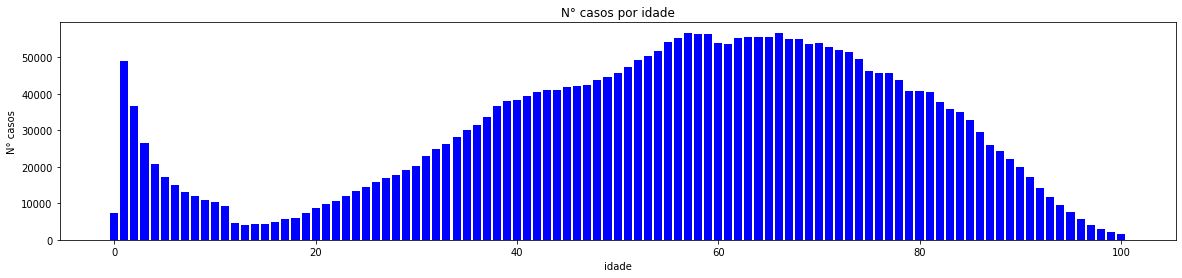

,N_pessoas
NU_IDADE_N,
0,7225
1,48953
2,36803
3,26658
4,20675
...,...
96,5618
97,4171
98,3003


In [ ]:
Npessoas_idade = df[["NU_IDADE_N","DT_NOTIFIC"]].groupby(by="NU_IDADE_N").count() 
Npessoas_idade = Npessoas_idade.rename(columns={"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame() 
grafico_barra(Npessoas_idade.N_pessoas,title = "N° casos por idade",xlabel = "idade",ylabel = "N° casos")
Npessoas_idade

### Idades fora dos limites

#### negativas

In [ ]:
df_negativa = df_quarta_idade[df_quarta_idade.NU_IDADE_N < 0] 

Média de idade: -3.55
Desvio padrão da idade: 3.21
idades dentro de 1 desvio padrão:   [-6.76, -0.33999999999999986]
idades dentro de 2 desvios padrões: [-9.969999999999999, 2.87]


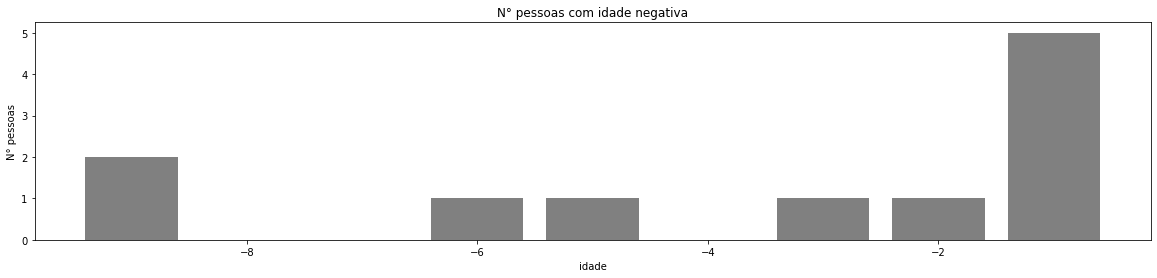

,NU_IDADE_N,DT_NASC,DT_NOTIFIC,DT_SIN_PRI
1575591,-9,2020-12-08,2021-03-16,2021-03-10
2926456,-9,2021-10-02,2022-02-11,2022-01-25
2336456,-6,2021-07-05,2022-01-04,2022-01-01
2794752,-5,2015-08-16,2021-03-27,2021-03-24
542197,-3,2020-02-19,2020-09-30,2020-09-27
2217955,-2,2018-09-05,2021-07-09,2021-07-05
691320,-1,2020-08-02,2020-08-02,2020-08-02
979494,-1,2020-12-12,2020-12-13,2020-12-13
1119076,-1,2020-10-13,2020-11-07,2020-10-28
2362349,-1,2020-02-21,2021-01-26,2021-01-19


In [ ]:
plot_por_idade(df_negativa,Npessoas_idade,titulo = f"pessoas com idade negativa",color = 'grey',taxa = False,return_distributions = False)

df_negativa.sort_values(by = "NU_IDADE_N")[["NU_IDADE_N","DT_NASC","DT_NOTIFIC","DT_SIN_PRI"]]

#### mais de 100 anos

In [ ]:
df_maior100 = df_quarta_idade[df_quarta_idade["NU_IDADE_N"] > 100]

Média de idade: 103.43
Desvio padrão da idade: 3.51
idades dentro de 1 desvio padrão:   [99.92, 106.94000000000001]
idades dentro de 2 desvios padrões: [96.41000000000001, 110.45]


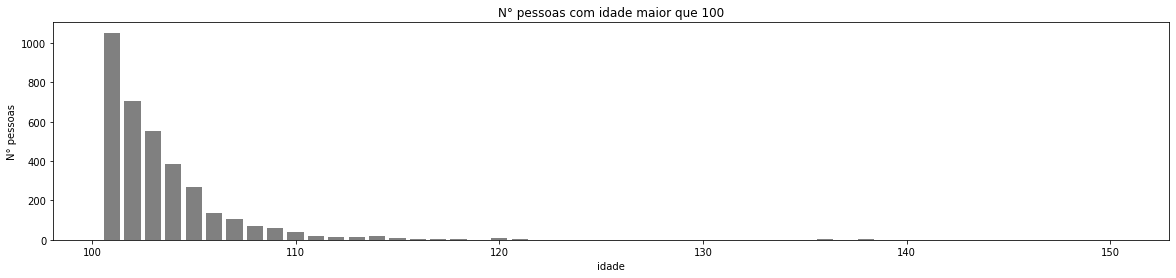

,NU_IDADE_N,DT_NASC,DT_NOTIFIC,DT_SIN_PRI
1520477,101,1920-02-18,2021-03-22,2021-03-14
745429,101,1919-04-27,2020-11-01,2020-10-31
3019399,101,1920-01-18,2022-01-07,2022-01-07
2925000,101,1920-06-21,2022-01-08,2022-01-06
1691121,101,1919-08-10,2021-06-14,2021-06-10
...,...,...,...,...
15221,138,1882-06-08,2020-06-26,2020-06-20
907281,138,1881-07-15,2020-05-20,2020-05-12
2455690,140,1880-08-10,2021-05-26,2021-02-18
83982,148,1872-02-05,2020-12-26,2020-12-21


In [ ]:
plot_por_idade(df_maior100,Npessoas_idade,titulo = f"pessoas com idade maior que 100",color = 'grey',taxa = False,return_distributions = False)

df_maior100.sort_values(by = "NU_IDADE_N")[["NU_IDADE_N","DT_NASC","DT_NOTIFIC","DT_SIN_PRI"]]

# Checando se existem datas na Coluna UTI fora do padrão

In [ ]:
print("Casos sem status na UTI:",   df[~df['UTI'].between(1,10)]['UTI'].shape[0])
print("Casos sem entrada na UTI:",  df[df['UTI'] == 2]['UTI'].shape[0])
print("Casos com entrada na UTI:",  df[df['UTI'] == 1]['UTI'].shape[0])
print("Casos Ignorados:",            df[df['UTI']== 9]['UTI'].shape[0])
total =  df[~df['UTI'].between(1,10)]['UTI'].shape[0] + df[df['UTI'] == 2]['UTI'].shape[0] + df[df['UTI'] == 1]['UTI'].shape[0] +  df[df['UTI']== 9]['UTI'].shape[0]
print("soma dos casos anteriores:",total)
print("total da base:            ",df.shape[0])

Casos sem status na UTI: 436797
Casos sem entrada na UTI: 1698005
Casos com entrada na UTI: 895273
Casos Ignorados: 63079
soma dos casos anteriores: 3093154
total da base:             3093154


# Verificando casos de UTI imediatamente ao nascer

In [ ]:
verificando = df.index[(df['DT_NASC'] == df['DT_ENTUTI'])]
print(f'N° de bebes que ao nascer foram internados na uti: {len(verificando)}')

N° de bebes que ao nascer foram internados na uti: 2705


Também foram encotrados casos de pessoas que tomaram ambas as doses no mesmo dia (Janssen?)

In [ ]:
#Eliminando doses em um dia
verificando3 = df.index[(df['DOSE_1_COV'] == df['DOSE_2_COV'])]
print(f'N° de pessoas que tomar 2 doses no mesmo dia:{len(verificando3)}')


df_doses_janssen = df[(df['DOSE_1_COV'] == df['DOSE_2_COV'])]

#se rodar essa celula uma segunda vez o resultado vai ser 0 por causa do drop 
df.drop(index = verificando3, inplace = True)


N° de pessoas que tomar 2 doses no mesmo dia:882


In [ ]:
verificando_entra_depois_de_saida = df.index[(df['DT_ENTUTI'] > df['DT_SAIDUTI'])]
print(f'N° de pessoas que sairam antes de entrar na UTI: {len(verificando_entra_depois_de_saida)}')
df.drop(index = verificando_entra_depois_de_saida, inplace = True)

N° de pessoas que sairam antes de entrar na UTI: 0


# Semanas epidemiológicas

#### Sem erros nas colunas das semanas epidemiológicas

In [ ]:
df[pd.isnull(df['SEM_NOT'])]['SEM_NOT']

Series([], Name: SEM_NOT, dtype: int64)

Um ano tem 52 semanas, levando em consideração que começam da semana 1 e não zero , teremos que as semanas epidemiológicas variam de 1 até 53

In [ ]:
print("N° casos com semana epidemiológica fora do intervalo [1,53]:")
print("Notificação: ",df[~df['SEM_NOT'].between(1,53)]['SEM_NOT'].shape[0])  
print("1° sintoma : ",df[~df['SEM_PRI'].between(1,53)]['SEM_PRI'] .shape[0])  

N° casos com semana epidemiológica fora do intervalo [1,53]:
Notificação:  0
1° sintoma :  0


In [ ]:
for col in ["DT_NOTIFIC","DT_SIN_PRI"]:
    nome_col_ano = "ANO_" + col
    df[nome_col_ano] = df[col].dt.year # pega ano


In [ ]:
df["DIA_PRI"] = (df["DT_SIN_PRI"] - pd.to_datetime("01/01/2020")).map(lambda x: int(x.days) + 1)
df["DIA_NOT"] = (df["DT_NOTIFIC"] - pd.to_datetime("01/01/2020")).map(lambda x: int(x.days) + 1)
df[["DIA_NOT","DIA_PRI"]]

,DIA_NOT,DIA_PRI
0,10,7
2,44,39
3,27,26
4,16,10
5,57,55
...,...,...
3107768,770,770
3107769,796,777
3107770,785,779
3107771,780,770


#### Adequando colunas de semana epidemiológica

* semana += 53, se ano == 2021
* semana += 2*53, se ano == 2022

In [ ]:
#REMOVER ESTA CELULA
df["SEM_NOT"].max()

53

In [ ]:
# REMOVER ESTA CELULA
(df["SEM_NOT"] + 53*(df["ANO_DT_NOTIFIC"] - 2020)).sort_values().to_frame()[(df["SEM_NOT"] + 53*(df["ANO_DT_NOTIFIC"] - 2020)).sort_values() > 150].drop_duplicates()

,0
1708503,158


In [ ]:
df["SEM_PRI"] =   df["SEM_PRI"] + (df["ANO_DT_SIN_PRI"] - 2020)*53
df["SEM_NOT"] =   df["SEM_NOT"] + (df["ANO_DT_NOTIFIC"] - 2020)*53

In [ ]:
print("NOTIFICAÇÃO:")
N_erros1 = df[["DIA_NOT","SEM_NOT"]][(df.DIA_NOT//7+ 1 > df.SEM_NOT+1) | (df.DIA_NOT//7+ 1 < df.SEM_NOT-1)].shape[0]
N_erros2 = df[["DIA_NOT","SEM_NOT"]][(df.DIA_NOT//7+ 1 > df.SEM_NOT+2) | (df.DIA_NOT//7+ 1 < df.SEM_NOT-2)].shape[0]
print(f"{round(100*N_erros1/df.shape[0],2)}% tem erro de mais de uma semana epidemiológica")
print(f"{round(100*N_erros2/df.shape[0],2)}% tem erro de mais de duas semanas epidemiológicas")

print("-"*20)

print("PRIMEIROS SINTOMAS:")
N_erros1 = df[["DIA_PRI","SEM_PRI"]][(df.DIA_PRI//7+ 1 > df.SEM_PRI+1) | (df.DIA_PRI//7+ 1 < df.SEM_PRI-1)].shape[0]
N_erros2 = df[["DIA_PRI","SEM_PRI"]][(df.DIA_PRI//7+ 1 > df.SEM_PRI+2) | (df.DIA_PRI//7+ 1 < df.SEM_PRI-2)].shape[0]
print(f"{round(100*N_erros1/df.shape[0],2)}% tem erro de mais de uma semana epidemiológica")
print(f"{round(100*N_erros2/df.shape[0],2)}% tem erro de mais de duas semanas epidemiológicas")

NOTIFICAÇÃO:
2.09% tem erro de mais de uma semana epidemiológica
0.23% tem erro de mais de duas semanas epidemiológicas
--------------------
PRIMEIROS SINTOMAS:
2.38% tem erro de mais de uma semana epidemiológica
0.58% tem erro de mais de duas semanas epidemiológicas


#### Checar se houve semana sem casos


In [ ]:
print("NOTIFICAÇÃO:")
erro = last = 0
for i in df['SEM_NOT'].drop_duplicates().sort_values()[:-1]:
    if i != last+1:print(i,"semana sem");erro = True;last = i-1
    last+=1
if not erro: print("todas semanas presentes")

print("-"*20)

print("PRIMEIROS SINTOMAS:")
erro = last = 0
for i in df['SEM_PRI'].drop_duplicates().sort_values()[:-1]:
    if i != last+1:print(i,"semana sem");erro = True;last = i-1
    last+=1
if not erro: print("todas semanas presentes")

NOTIFICAÇÃO:
todas semanas presentes
--------------------
PRIMEIROS SINTOMAS:
todas semanas presentes


#### Distribuição por dia

In [ ]:
df_dia = df[["DIA_PRI","DT_NOTIFIC"]].groupby(by="DIA_PRI").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"}).N_pessoas

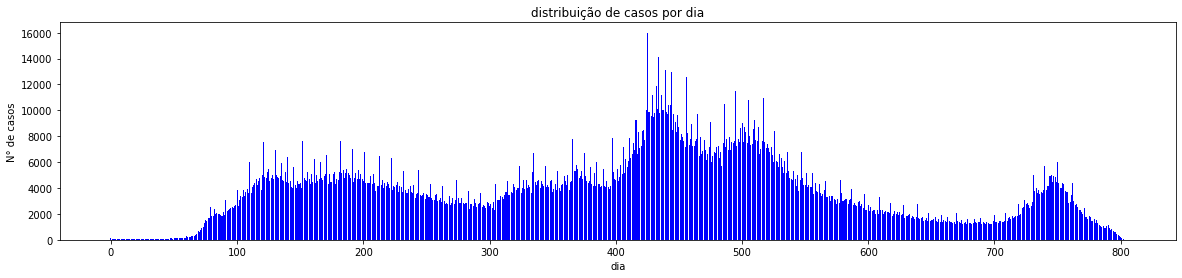

In [ ]:
grafico_barra(df_dia,xlabel = "dia",ylabel = "N° de casos",title = "distribuição de casos por dia")

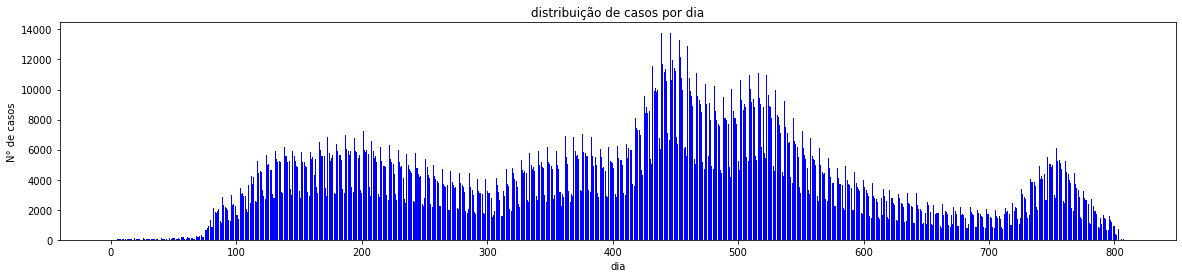

In [ ]:
grafico_barra(df[["DIA_NOT","DT_NOTIFIC"]].groupby(by="DIA_NOT").count().rename(columns = {"DT_NOTIFIC": "N_casos"}).N_casos,xlabel = "dia",ylabel = "N° de casos",title = "distribuição de casos por dia")

# Ondas

## Notícia

https://diariodepetropolis.com.br/integra/secretaria-mostra-estudo-com-avaliacao-das-cinco-ondas-da-covid-19-no-rj-207935


https://www.saude.rj.gov.br/noticias/2022/03/secretaria-de-saude-divulga-estudo-com-avaliacao-das-cinco-ondas-da-covid-19-no-estado-do-rio-de-janeiro

(Grifos e organização em tópicos são meus)

1. Na **1ª onda,** ocorrida entre os meses de abril e maio de 2020 **(05/04 a 23/05 de 2020),** a predominância foi da **variante B.1.1.33,** cepa inicial que chegou ao Brasil. 
Ela não era considerada uma cepa de preocupação (VOC) e já se encontrava em todos os continentes do mundo. 
Durante essa onda, foram registrados 99.760 casos, 24.174 internações e 11.270 óbitos. 

2. A **2ª onda** ocorreu entre os meses de novembro de 2020 e janeiro de 2021 **(08/11/2020 a 16/01/2021),** com predomínio da P.2 **(Zeta)**, 
considerada uma variante de interesse (VOI) e identificada primeiro no Rio de Janeiro e depois nos demais estados. 
No período, foram registrados 282.339 casos, 27.778 internações e 10.621 óbitos.

3. A **3ª onda** teve início em fevereiro de 2021, devido à entrada da variante P.1 **(Gama)** no estado. 
Ela foi detectada primeiro em Manaus e depois no restante do país. Esta foi a onda com a maior duração, 
ocorrendo até meados do mês de junho **(28/02/2021 a 12/06/2021).** 
Foram 358.980 casos notificados, 55.150 internações e 20.079 óbitos. 

4. Em **agosto de 2021,** o estado entrou na **4ª onda** com a chegada da variante A.Y.99.2 **(Delta)** 
ao país. O diferencial desta onda foi ter ocorrido após o início da campanha de vacinação (janeiro de 2021). 
Ela se mostrou menos transmissível que as outras, registrando 71.053 casos, 6.772 internações e 2.524 óbitos.

5. A **5ª onda** gerada pela entrada da variante BA.1 **(Ômicron)** no país aconteceu entre **dezembro de 2021 e janeiro de 2022.** 
Até o momento, esta foi a onda que apresentou a curva mais elevada de casos. 
Embora tenha sido a maior em número de casos (459.099), representou o **menor número de internações**, 4.607, e 1.475 óbitos, 
refletindo a efetividade da vacinação contra Covid-19.


| Nº da Onda| Data Inicial  |  Data Final |  Nome da Variante |
|-----------|:-------------:|------------:|------------------:|
| 1ª Onda   |  05/04/2020   | 23/05/2020  |  		B.1.1.33
| 2ª Onda   |  08/11/2020   |  16/01/2021 |			Zeta
| 3ª Onda   | 28/02/2021    |  12/06/2021 |			Gama
| 4ª Onda   | 08/2021       |  14/12/2021 |			Delta
| 5ª Onda   | 15/12/2021    |  13/04/2022 |			Ômicron


FAVOR FAZER UMA TABELA NO MARKDOWN DOS DADOS ABAIXO.

COM AS COLUNAS: N° DA ONDA, DATA INICIAL, DATA FINAL, NOME DA VARIANTE

1. 1ª onda  (05/04 a 23/05 de 2020), (variante B.1.1.33, cepa inicial que chegou ao Brasil)
2. 2ª onda 08/11/2020 a 16/01/2021, (Zeta),
3. 3ª onda 28/02/2021 a 12/06/2021, (Gama)
4. 4ª onda agosto de 2021 (08/2021), (Delta)
5. 5ª onda 12/2021 e 01/2022 BA.1 (Ômicron) 




ABORDAGEM 1

É plausível considerar que o estudo local realizado no estado do Rio de Janeiro pode seguir de guia na datação das ondas das variantes do COVID-19 para o Brasil como um todo. Perídos em que as datas exatas não foram definidas serão considerados valores intermediários.

1. 1ª onda  (05/04/2020 [dia 95] a 23/05/2020 [dia 143]) (variante B.1.1.33)
2. 2ª onda (08/11/2020 [dia 312] a 16/01/2021 [dia 381]) (Zeta)
3. 3ª onda (28/02/2021 [dia 424] a 12/06/2021 [dia 528]) (Gama)
4. 4ª onda (15/08/2021 [dia 592] a 14/12/2021 [dia 713]) (Delta)
5. 5ª onda (15/12/2021 [dia 714] a 13/04/2022(hoje) [dia 833] )(Ômicron) 


**Para fins de simplificação, não será considerado que ondas de variantes distintas coexistem**



ABORDAGEM 2

Artigo: https://preprints.scielo.org/index.php/scielo/preprint/download/2316/3905/4037
Utilizar de dados referentes à todo o Brasil para 1º e 2º ondas, **as quais não foram atrubidas a uma variante em específico**. Note que é necessário de alguma forma modelar as demais ondas

1. 1ª onda  (23/02/2020 [dia 53] a 07/11/2020 [dia 311]) 
2. 2ª onda (14/11/2020 [dia 318] a 17/04/2021 [dia 472]) 













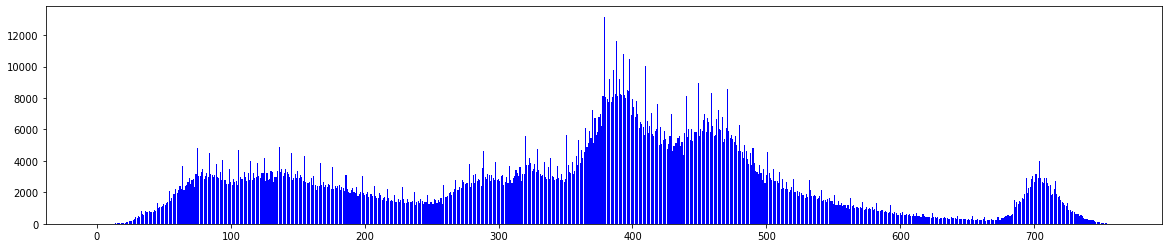

DIA_PRI
47      5
48     11
49      8
50      6
51      7
       ..
800    31
801    22
802    14
803     4
804     2
Name: N_pessoas, Length: 758, dtype: int64

In [ ]:
df_cov_dia = df[df["CLASSI_FIN"] == 5][["DIA_PRI","DT_NOTIFIC"]].groupby(by="DIA_PRI").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"}).N_pessoas
grafico_barra(df_cov_dia)
df_cov_dia

##Análise

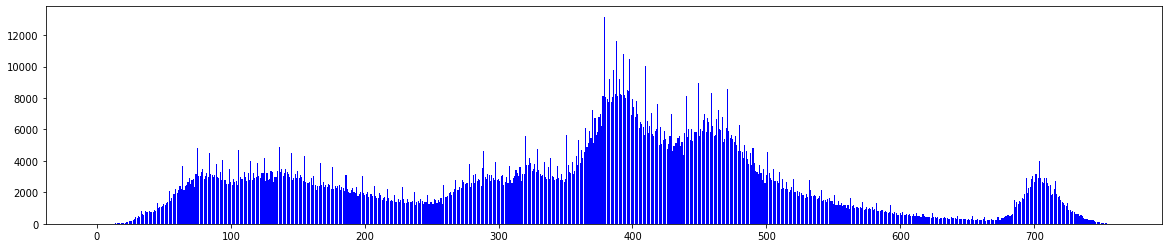

In [ ]:
arr = []
for anterior,numero,posterior in zip(df_cov_dia.iloc[:-2],df_cov_dia[1:-1],df_cov_dia.iloc[2:]):
    media =  (anterior+posterior)/2
    arr.append(    1.1*media if numero > 1.1*media else numero)
df_cov_dia.N_pessoas = pd.Series(arr)
grafico_barra(df_cov_dia)

### Função de análise

In [ ]:
def analise_fft(df_dia = df_dia, primeiro_dia = 0,ultimo_dia = 800,treshold_min = None,treshold_max = None,titulo_filtro = "N° casos no dia (normalizado)", return_f = False ):
    y = (df_dia[primeiro_dia:ultimo_dia]- df_dia[primeiro_dia:ultimo_dia].mean() )/df_cov_dia[primeiro_dia:ultimo_dia].max()
    
    N = y.size
    x = np.linspace(primeiro_dia,primeiro_dia+  N,N)



    y_f = np.fft.fft(y)
    x_f = np.linspace(0,N//2, N//2)

    plt.title("power spectrum")
    plt.plot(x_f, np.abs(y_f[:N//2]))
    plt.show()
    print()

    if treshold_min is not None:
        y_f = y_f*(treshold_min < np.abs(y_f))
    if treshold_max is not None:
        y_f = y_f*(treshold_max > np.abs(y_f))


    y_f = y_f
    y_0 = np.fft.ifft(y_f)

    plt.title("original")
    plt.plot(x, y)
    plt.show()

    plt.title("recovered after filter and ifft")
    plt.plot(x, y_0)
    plt.show()

    if return_f:
        return y_0


### Todos os dias


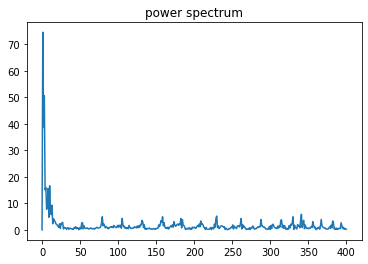

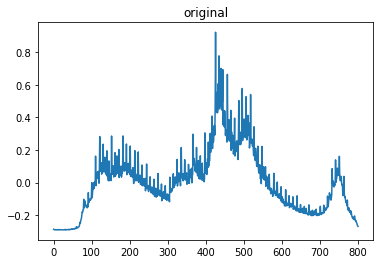

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


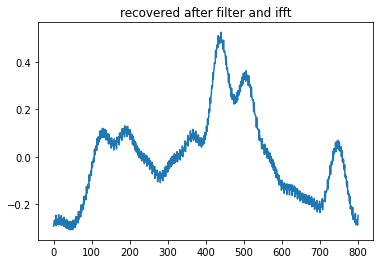

In [ ]:
analise_fft(treshold_min=5)

### Primeira e Segunda ondas. Dias: 100-360

Percebemos que as 5 ondas correspondentes Às maiores amplitudes possuem período de 260 (o trecho interio selecionado), 65, 52 e 5.

A mais forte é a de 260 que possui dois cumes, que correspondem a primeira e segunda onda da covid

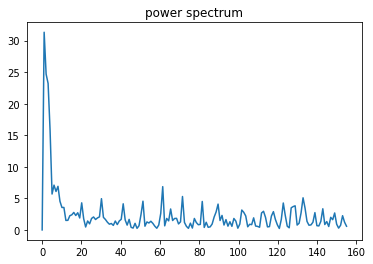

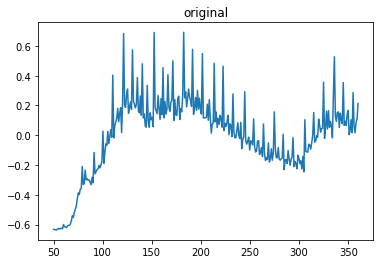

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


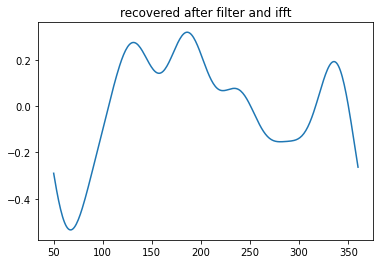

In [ ]:
analise_fft(primeiro_dia = 50, ultimo_dia = 360,treshold_min=7)

Aparentes pontos de início e fim das ondas


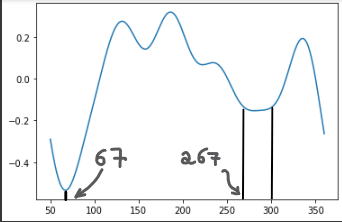

### Terceira e quarta Onda. Dias: 400 - 713

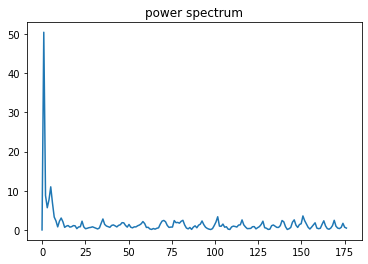

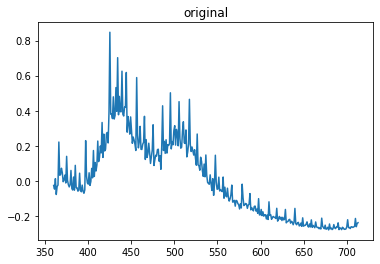

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


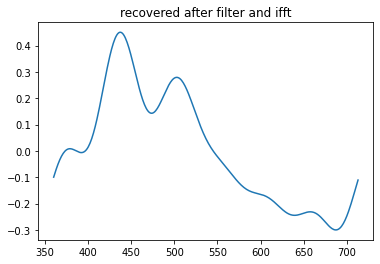

In [ ]:
analise_fft(primeiro_dia =  360, ultimo_dia = 713,treshold_min=5)

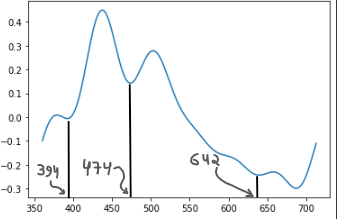

### Quarta onda para frente

4° onda: agosto de 2021

5° onda: dezembro de 2021

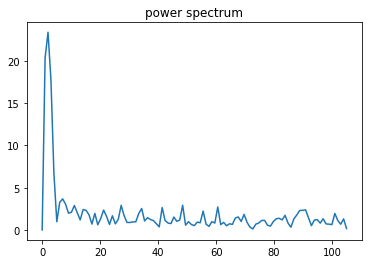

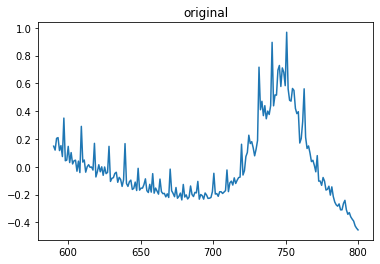

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


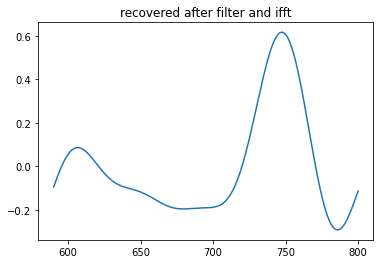

In [ ]:
analise_fft(primeiro_dia = 590,treshold_min=6)

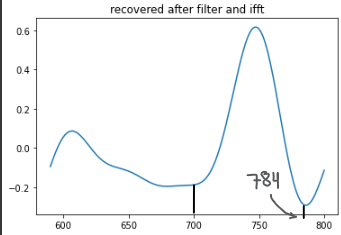

## Atribuição da onda a cada caso

ACHAR A DATA OLHANDO AS ONDAS E VENDO ONDE COMEÇA E ACABA CADA UMA.



In [ ]:
df["ONDA"] = 0

Datas coletadas pela filtragem do fft
1. 08/03/2020 - 25/09/2020
1. 08/11/2020 - 02/02/2021
1. 29/01/2021 - 20/04/2021
1. 21/04/2021 - 04/10/2021
1. 01/12/2021 - 26/02/2022


In [ ]:
df["ONDA"]= ( 
               ( (pd.to_datetime("08/03/2020",dayfirst = True) <= df["DT_SIN_PRI"])  & (df["DT_SIN_PRI"] <= pd.to_datetime("25/09/2020",dayfirst = True)))*1 
            +  ( (pd.to_datetime("08/11/2020",dayfirst = True) <= df["DT_SIN_PRI"])  & (df["DT_SIN_PRI"] <= pd.to_datetime("02/02/2021",dayfirst = True)))*2
            +  ( (pd.to_datetime("03/02/2021",dayfirst = True) <= df["DT_SIN_PRI"])  & (df["DT_SIN_PRI"] <= pd.to_datetime("20/04/2021",dayfirst = True)))*3 
            +  ( (pd.to_datetime("21/04/2021",dayfirst = True) <= df["DT_SIN_PRI"])  & (df["DT_SIN_PRI"] <= pd.to_datetime("04/10/2021",dayfirst = True)))*4 
            +  ( (pd.to_datetime("01/12/2021",dayfirst = True) <= df["DT_SIN_PRI"])                                                                      )*5 
            )


In [ ]:
d = lambda data: pd.to_datetime(data,dayfirst = True)
( d("08/11/2020") - d("25/09/2020") ).days

def linearizacao(data1,data2,data,b):
    data1 = d(data1)
    data2 = d(data2)
    
    a     = 1/(data2 - data1).days
    delta = (data  - data1).days
    
    y = a*delta + b

    return y

linearizacao("25/09/2020","08/11/2020",df["DT_SIN_PRI"].iloc[0],1)

-4.954545454545455

In [ ]:
df["ONDA"] = np.where(
    (df["DT_SIN_PRI"] < d("08/03/2020")),   
    (df["DT_SIN_PRI"]-d("01/01/2020"))/(d("08/03/2020")-d("01/01/2020")),
    df["ONDA"]
)

df["ONDA"] = np.where(
    (d("25/09/2020") < df["DT_SIN_PRI"])  & (df["DT_SIN_PRI"] < d("08/11/2020") ),   
    (df["DT_SIN_PRI"]-d("25/09/2020"))/(d("08/11/2020")-d("25/09/2020")) + 1,
    df["ONDA"]
)

df["ONDA"] = np.where(
    (d("04/10/2021") < df["DT_SIN_PRI"])  & (df["DT_SIN_PRI"] < d("01/12/2021") ),   
    (df["DT_SIN_PRI"]-d("04/10/2021"))/(d("01/12/2021")-d("04/10/2021")) + 4,
    df["ONDA"]
)


In [ ]:
df[df["ONDA"] == 0]["DT_SIN_PRI"].unique()

array(['2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

# Fatores de risco

In [ ]:
lista_fatores = [
    "FATOR_RISC",
"CARDIOPATI",
"ASMA",
"PNEUMOPATI",
"DIABETES",
"IMUNODEPRE",
"OBESIDADE",]

## Obesidade


A maioria dos casos de obesidade nao possui IMC registrada. Infelizmente, temos casos de obesidade sem sentido (com IMC muito pequeno). Por isso vamos apenas considerar obesidades registradas como morbida ($IMC \ge 40$ )

Além disso, manteremos apenas aqueles com: $ 10 \le IMC \le 80$ 

In [ ]:
df_obesos_por_IMC = df[["OBES_IMC","DT_NOTIFIC","NU_IDADE_N"]].groupby(by = "OBES_IMC").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()
df_obesos_por_IMC

,N_pessoas
OBES_IMC,
0,3117
"0,03",5
"0,1",2034
"0,2",450
"0,3",89
...,...
96,1
98,5
"98,7",1


#### Conversão dos valores de obesidade

In [ ]:
def conversion(numero_str):
    f = None
    try:
        f= float(numero_str.replace(',','.'))
    except:
        1+1
        #print(numero_str,type(numero_str))
    return f

#### Converter IMC para float

In [ ]:
df["OBES_IMC"] = df["OBES_IMC"].apply(conversion)

df[df["OBESIDADE"] == 1][pd.isnull(df["OBES_IMC"])== False][["OBES_IMC","OBESIDADE"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,OBES_IMC,OBESIDADE
89,37.2,1.0
119,49.8,1.0
136,4.1,1.0
146,5.6,1.0
180,40.0,1.0
...,...,...
3107314,0.0,1.0
3107402,40.0,1.0
3107409,1.0,1.0
3107482,29.4,1.0


#### SUPER OBESOS

In [ ]:
obesos_int = round(df[["OBES_IMC","DT_NOTIFIC","NU_IDADE_N"]][ pd.isnull(df["OBES_IMC"])  == False ]) # aproximando o IMC para inteiro
obesos_int_por_IMC = obesos_int[obesos_int.OBES_IMC < 80][obesos_int.OBES_IMC > 10].groupby(by = "OBES_IMC").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()
obesos_int.sort_values(by="OBES_IMC")[(obesos_int.OBES_IMC > 100)][["OBES_IMC","NU_IDADE_N"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,OBES_IMC,NU_IDADE_N
2447845,284.0,55
331425,286.0,85
72804,327.0,22
1645214,329.0,78
2381266,363.0,68
1125697,403.0,39
454961,410.0,44
2501436,419.0,49
1615839,425.0,51
708926,620.0,51


#### SUPER DESNUTRIDOS

In [ ]:
obesos_int.sort_values(by="OBES_IMC")[(obesos_int.OBES_IMC < 10)].groupby(by = "OBES_IMC").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})["N_pessoas"].to_frame()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,N_pessoas
OBES_IMC,
0.0,5738
1.0,821
2.0,156
3.0,616
4.0,868
5.0,80
6.0,30
7.0,6
8.0,5


In [ ]:
df_morbidos = df[["OBES_IMC","NU_IDADE_N","DT_NOTIFIC"]][df["OBES_IMC"] >=40.0]
df_morbidos

,OBES_IMC,NU_IDADE_N,DT_NOTIFIC
119,49.8,33,2020-04-01
180,40.0,41,2020-04-09
362,42.4,28,2020-05-07
376,99.9,61,2020-05-04
567,41.0,39,2020-05-14
...,...,...,...
3098837,61.7,33,2022-01-27
3100047,47.0,61,2022-02-11
3100926,40.0,55,2022-01-14
3102800,43.7,18,2022-02-16


In [ ]:
df[(pd.isnull(df["OBES_IMC"])  | pd.isnull(df["OBESIDADE"])) & (df["OBESIDADE"] != False) & (df["OBES_IMC"] != False)]

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,SEM_PRI,ANO_DOSE_1_COV,ANO_DOSE_2_COV,ANO_DT_ENTUTI,ANO_DT_INTERNA,ANO_DT_NOTIFIC,ANO_DT_SIN_PRI,DIA_PRI,DIA_NOT,ONDA
0,7,S,NaN,NaN,1.0,NaN,1.0,NaN,NaN,2,...,2,NaN,NaN,NaN,2020,2020,2020,7,10,0.089552
2,57,S,1.0,2.0,2.0,1.0,2.0,2.0,NaN,2,...,6,NaN,NaN,2020,2020,2020,2020,39,44,0.567164
3,9,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,5,NaN,NaN,NaN,2020,2020,2020,26,27,0.373134
4,1,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,2,NaN,NaN,NaN,2020,2020,2020,10,16,0.134328
5,28,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,9,NaN,NaN,NaN,NaN,2020,2020,55,57,0.805970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3107768,41,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,112,2021,2021,NaN,2022,2022,2022,770,770,5.000000
3107769,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,...,113,NaN,NaN,2022,2022,2022,2022,777,796,5.000000
3107770,89,1,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1,...,113,2021,2021,NaN,2022,2022,2022,779,785,5.000000
3107771,81,1,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1,...,112,2021,2021,NaN,2022,2022,2022,770,780,5.000000


In [ ]:
df[ df.OBES_IMC >= 30.0][df.OBESIDADE !=1][["OBES_IMC", "OBESIDADE" ,"NU_IDADE_N"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,OBES_IMC,OBESIDADE,NU_IDADE_N


In [ ]:
# se df.OBES_IMC is np.NaN ---> 9.0, 
# pois (np.NaN comparador outra_coisa) == False
# para ver isto, rode: np.NaN < 10

df_erro_IMC = df[ (df["OBES_IMC"] > 80) | (df["OBES_IMC"] < 10 ) ]
df.drop(df_erro_IMC.index , inplace = True)

df.OBESIDADE = np.where( df.OBES_IMC >= 30.0, 1, df.OBESIDADE )

df["OBES_MORB"] = ( 1.0*(df.OBES_IMC >= 40.0)  + 2.0*(df.OBES_IMC < 40.0)  ) + 9.0*(pd.isnull(df.OBES_IMC))
df[df["OBES_MORB"] == 1.0]

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,ANO_DOSE_1_COV,ANO_DOSE_2_COV,ANO_DT_ENTUTI,ANO_DT_INTERNA,ANO_DT_NOTIFIC,ANO_DT_SIN_PRI,DIA_PRI,DIA_NOT,ONDA,OBES_MORB
119,33,S,NaN,NaN,NaN,NaN,NaN,1.0,49.8,2,...,NaN,NaN,NaN,2020,2020,2020,90,92,1.0,1.0
180,41,S,1.0,2.0,2.0,2.0,2.0,1.0,40.0,2,...,NaN,NaN,NaN,2020,2020,2020,95,100,1.0,1.0
362,28,S,1.0,1.0,2.0,2.0,2.0,1.0,42.4,2,...,NaN,NaN,NaN,2020,2020,2020,114,128,1.0,1.0
567,39,S,NaN,NaN,NaN,NaN,NaN,1.0,41.0,2,...,NaN,NaN,2020,2020,2020,2020,134,135,1.0,1.0
572,55,S,1.0,2.0,2.0,2.0,2.0,1.0,42.7,2,...,NaN,NaN,NaN,2020,2020,2020,114,125,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098837,33,1,1.0,2.0,2.0,2.0,2.0,1.0,61.7,1,...,NaN,NaN,2022,2022,2022,2022,755,758,5.0,1.0
3100047,61,1,1.0,NaN,NaN,NaN,NaN,1.0,47.0,2,...,NaN,NaN,2022,2022,2022,2022,741,773,5.0,1.0
3100926,55,1,1.0,2.0,2.0,1.0,2.0,1.0,40.0,1,...,2021,2021,2022,2022,2022,2022,741,745,5.0,1.0
3102800,18,1,NaN,NaN,NaN,NaN,NaN,1.0,43.7,2,...,NaN,NaN,NaN,NaN,2022,2022,761,778,5.0,1.0


#### Distribuição de obesos com IMC entre 10 e 80





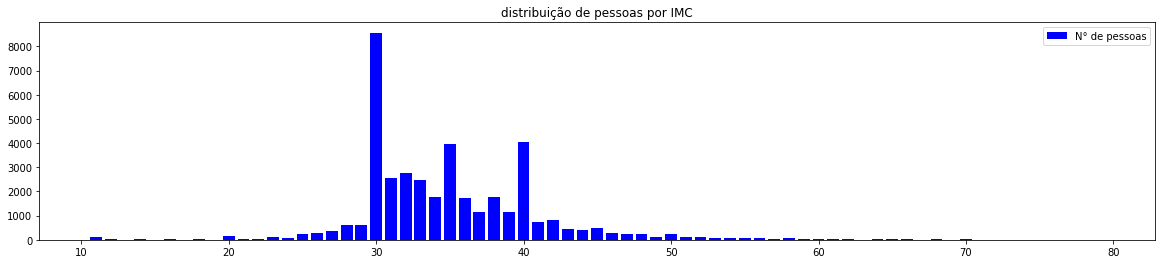

In [ ]:

plt.figure(figsize=(20, 4)) 
plt.bar(obesos_int_por_IMC.index, obesos_int_por_IMC.N_pessoas, color = 'b', label='N° de pessoas',)

plt.title("distribuição de pessoas por IMC")
plt.legend()
plt.show()

#### Limpando a memória

In [ ]:
del df_obesos_por_IMC
del obesos_int_por_IMC
del obesos_int
del df_morbidos

## Fator de risco

não há casos de fator de risco não preenchido

In [ ]:
df[pd.isnull(df["FATOR_RISC"])]

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,ANO_DOSE_1_COV,ANO_DOSE_2_COV,ANO_DT_ENTUTI,ANO_DT_INTERNA,ANO_DT_NOTIFIC,ANO_DT_SIN_PRI,DIA_PRI,DIA_NOT,ONDA,OBES_MORB


# Limpando

##  S e N não estão descritos no dicionário de dados

Não sabemos o que seria S. Provavelmente Sim

In [ ]:
df[lista_fatores][df[lista_fatores]["FATOR_RISC"] == 'S']

,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE
0,S,NaN,NaN,1.0,NaN,1.0,NaN
2,S,1.0,2.0,2.0,1.0,2.0,2.0
8,S,2.0,2.0,2.0,2.0,2.0,2.0
10,S,1.0,2.0,2.0,2.0,2.0,2.0
11,S,1.0,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1199984,S,2.0,2.0,2.0,2.0,2.0,2.0
1199986,S,1.0,NaN,NaN,NaN,NaN,NaN
1199987,S,NaN,NaN,NaN,1.0,NaN,NaN
1199990,S,1.0,2.0,2.0,1.0,2.0,2.0


In [ ]:
df.FATOR_RISC = np.where(df["FATOR_RISC"] == 'S',1,df.FATOR_RISC)

O mesmo para N. Provavelmente "não"

In [ ]:
df[lista_fatores][df[lista_fatores]["FATOR_RISC"] == 'N']

,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE
3,N,NaN,NaN,NaN,NaN,NaN,NaN
4,N,NaN,NaN,NaN,NaN,NaN,NaN
5,N,NaN,NaN,NaN,NaN,NaN,NaN
6,N,NaN,NaN,NaN,NaN,NaN,NaN
7,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1199980,N,NaN,NaN,NaN,NaN,NaN,NaN
1199981,N,NaN,NaN,NaN,NaN,NaN,NaN
1199985,N,NaN,NaN,NaN,NaN,NaN,NaN
1199988,N,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.FATOR_RISC = np.where(df["FATOR_RISC"] == 'N',2,df.FATOR_RISC)

## Limpeza/padronização dos dados das colunas de comorbidades selecionadas

Não há nenhum dado que não seja NaN, 1.0, 2.0 , ou 9.0 .

**Faremos o casting de NaN para 9.0 (ignorado)**

In [ ]:
for col in lista_fatores[:-1]:
    print(df[(df[col] != 1.0) & (df[col] != 2.0) & (df[col] != 9.0) &  ( pd.isnull(df[col] ) == False )][col])

Series([], Name: FATOR_RISC, dtype: object)
Series([], Name: CARDIOPATI, dtype: float64)
Series([], Name: ASMA, dtype: float64)
Series([], Name: PNEUMOPATI, dtype: float64)
Series([], Name: DIABETES, dtype: float64)
Series([], Name: IMUNODEPRE, dtype: float64)


In [ ]:
for col in lista_fatores[:-1]:
    df[col] = np.where(pd.isnull(df[col]),9,df[col])
    
df[lista_fatores[:-1]]

,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE
0,1,9.0,9.0,1.0,9.0,1.0
2,1,1.0,2.0,2.0,1.0,2.0
3,2,9.0,9.0,9.0,9.0,9.0
4,2,9.0,9.0,9.0,9.0,9.0
5,2,9.0,9.0,9.0,9.0,9.0
...,...,...,...,...,...,...
3107768,2,9.0,9.0,9.0,9.0,9.0
3107769,2,9.0,9.0,9.0,9.0,9.0
3107770,1,1.0,2.0,2.0,2.0,2.0
3107771,1,1.0,2.0,2.0,2.0,2.0


## Atribuição dos fatores de riscos que selecionamos


Camaremos de fator de risco grave (por cionsiderarmos as comorbidades escolhidas as mais letais).

Câncer, doença pulmonar obstrutiva crônica (uma mistura entre bronquite e enfisema pulmonar), problemas cardíacos, como insuficiência cardíaca, doença arterial coronariana ou cardiomiopatias, sistema imunológico enfraquecido após transplantes de órgãos sólidos, obesidade com Índice de Massa Corporal (IMC) acima de 30, gravidez, tabagismo e diabetes mellitus tipo 2.

Leia mais em: https://veja.abril.com.br/coluna/diario-da-vacina/cancer-down-e-anemia-falciforme-as-piores-comorbidades-para-a-covid/

In [ ]:
df["FATOR_RISC_GRAVE"] = 1.0*( 
    (df[lista_fatores[1:]] == 1).any("columns") # se alguma coluna tiver comorbidade, fator_risc = 1 (com comorbidade)
    ) + 2.0*( 
            (df[lista_fatores[1:]]== 2).all("columns") # se todas colunas nao tiverem comorbidade, fator_risc = 2 (sem comorbidade)
            ) + 9.0*(
                    (df[lista_fatores[1:]] != 1 ).all("columns") & (df[lista_fatores[1:]] != 2).any("columns") # se nenhuma comorbidade, mas há uma comorbidade ignorada, fator_risc = 9 (ignorado)
                    )
df[["FATOR_RISC_GRAVE"]+lista_fatores]

,FATOR_RISC_GRAVE,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE
0,1.0,1,9.0,9.0,1.0,9.0,1.0,NaN
2,1.0,1,1.0,2.0,2.0,1.0,2.0,2.0
3,9.0,2,9.0,9.0,9.0,9.0,9.0,NaN
4,9.0,2,9.0,9.0,9.0,9.0,9.0,NaN
5,9.0,2,9.0,9.0,9.0,9.0,9.0,NaN
...,...,...,...,...,...,...,...,...
3107768,9.0,2,9.0,9.0,9.0,9.0,9.0,NaN
3107769,9.0,2,9.0,9.0,9.0,9.0,9.0,NaN
3107770,1.0,1,1.0,2.0,2.0,2.0,2.0,2.0
3107771,1.0,1,1.0,2.0,2.0,2.0,2.0,2.0


In [ ]:
for col in ["HOSPITAL","UTI","EVOLUCAO","TOMO_RES","RES_AN","PCR_RESUL","POS_AN_FLU","RES_IGG","RES_IGM","RES_IGA"]:
    print("\nvalores possíveis antes da limpeza: \n",df[col].drop_duplicates())
    df[col] = np.where(pd.isnull(df[col]  ), 9, df[col])
    print("\nvalores possíveis depois da limpeza:\n ",df[col].drop_duplicates())


valores possíveis antes da limpeza: 
 0      1.0
5      2.0
143    NaN
629    9.0
Name: HOSPITAL, dtype: float64

valores possíveis depois da limpeza:
  0      1.0
5      2.0
143    9.0
Name: HOSPITAL, dtype: float64

valores possíveis antes da limpeza: 
 0     2.0
2     1.0
5     NaN
70    9.0
Name: UTI, dtype: float64

valores possíveis depois da limpeza:
  0    2.0
2    1.0
5    9.0
Name: UTI, dtype: float64

valores possíveis antes da limpeza: 
 0     1.0
2     2.0
4     NaN
14    3.0
76    9.0
Name: EVOLUCAO, dtype: float64

valores possíveis depois da limpeza:
  0     1.0
2     2.0
4     9.0
14    3.0
Name: EVOLUCAO, dtype: float64

valores possíveis antes da limpeza: 
 0       NaN
5       6.0
20      9.0
38      1.0
229     5.0
316     3.0
331     2.0
1750    4.0
Name: TOMO_RES, dtype: float64

valores possíveis depois da limpeza:
  0       9.0
5       6.0
38      1.0
229     5.0
316     3.0
331     2.0
1750    4.0
Name: TOMO_RES, dtype: float64

valores possíveis antes da limp

# Análise do fator de risco (e morte) por idade

Média de idade: 61.3
Desvio padrão da idade: 19.86
idades dentro de 1 desvio padrão:   [41.44, 81.16]
idades dentro de 2 desvios padrões: [21.58, 101.02]


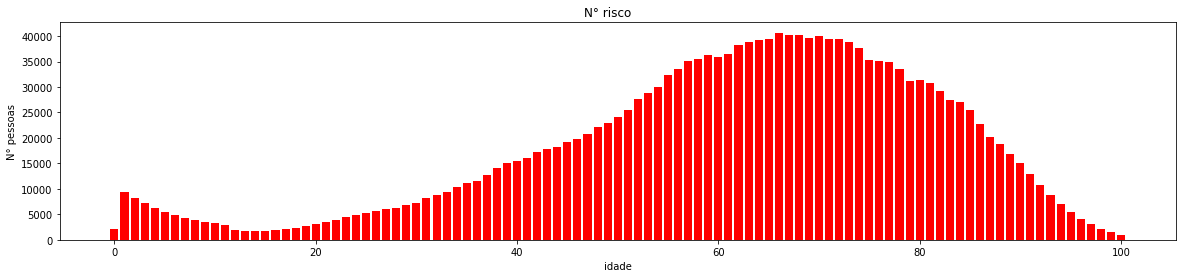

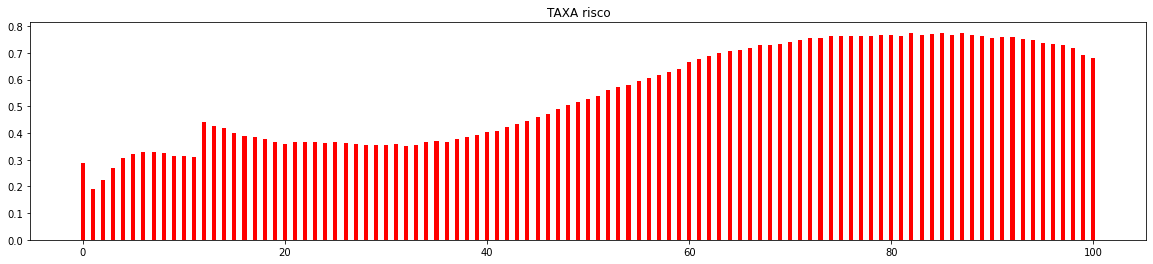




Média de idade: 45.96
Desvio padrão da idade: 23.6
idades dentro de 1 desvio padrão:   [22.36, 69.56]
idades dentro de 2 desvios padrões: [-1.240000000000002, 93.16]


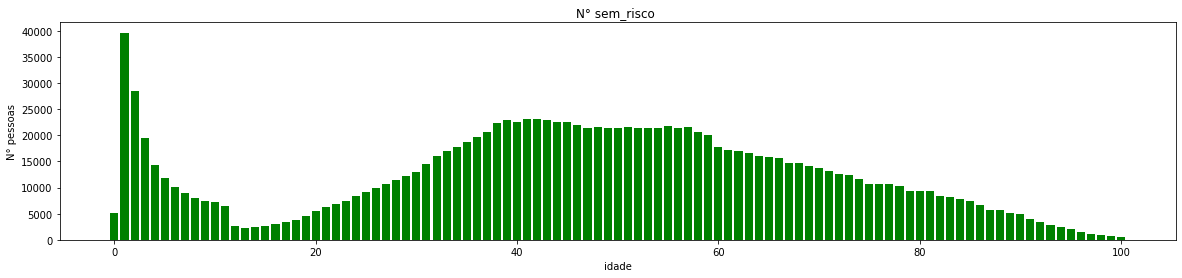

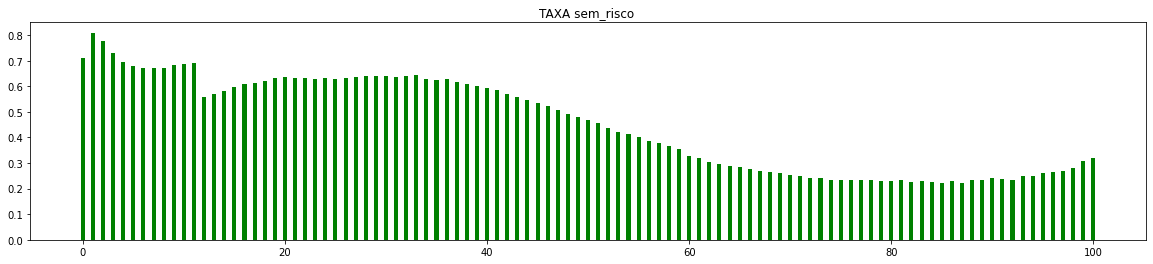

In [ ]:
df_risco        = df[df["FATOR_RISC"] == 1][["DT_NOTIFIC","NU_IDADE_N",	"FATOR_RISC","EVOLUCAO"]]
df_sem_risco    = df[df["FATOR_RISC"] == 2][["DT_NOTIFIC","NU_IDADE_N",	"FATOR_RISC","EVOLUCAO"]]

df_risco_por_idade    , df_sem_risco_por_idade_taxa = plot_por_idade(df_risco     , Npessoas_idade,taxa = True, titulo = "risco     ", titulo_taxa = "risco     ",color = 'red')
df_sem_risco_por_idade, df_risco_por_idade_taxa     = plot_por_idade(df_sem_risco , Npessoas_idade,taxa = True, titulo = "sem_risco ", titulo_taxa = "sem_risco ",color = 'green')

#### Comparação entre *Fator de risco* e *Fator  de risco grave*

A maior parte dos riscos são graves.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


N° casos com fator de risco:            1811650
N° casos com fator de risco não grave:  406031
N° casos com fator de risco grave:      1405619
N° casos com fator de risco grave, mas sem fator de risco:  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


mortalidade geral da base:                 25.0 %
mortalidade para fator de risco:           30.88 %
mortalidade para fator de risco não grave: 27.22 %
mortalidade para fator de risco grave:     31.94 %


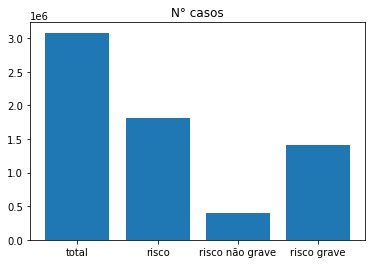

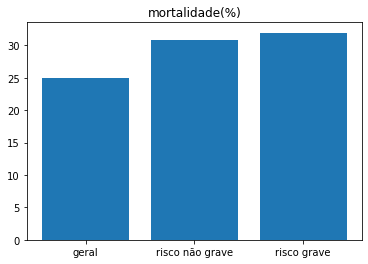

In [ ]:
N_risco_naograve= len(df[df["FATOR_RISC_GRAVE"] != 1][df["FATOR_RISC"] == 1])
N_risco_absurdo = len(df[df["FATOR_RISC_GRAVE"] == 1][df["FATOR_RISC"] != 1])
N_risco_grave   = len(df[df["FATOR_RISC_GRAVE"] == 1])
N_risco = len(df[df["FATOR_RISC"] == 1])

print("N° casos com fator de risco:           ",N_risco)
print("N° casos com fator de risco não grave: ",N_risco_naograve)
print("N° casos com fator de risco grave:     ",N_risco_grave)
print("N° casos com fator de risco grave, mas sem fator de risco: ",N_risco_absurdo)

N_risco_mortos                 =  len(df[df["FATOR_RISC"      ] == 1][df["EVOLUCAO"]== 2])
N_risco_naograve_mortos        =  len(df[df["FATOR_RISC"      ] == 1][df["FATOR_RISC_GRAVE"] != 1][df["EVOLUCAO"]== 2])
N_riscos_grave_mortos          =  len(df[df["FATOR_RISC_GRAVE"] == 1][df["EVOLUCAO"]== 2])

mortalidade_risco           = round(100*N_risco_mortos       /N_risco         ,2)
mortalidade_risco_naograve  = round(100*N_risco_naograve_mortos       /N_risco_naograve,2)
mortalidade_risco_grave     = round(100*N_riscos_grave_mortos/N_risco_grave   ,2)
mortalidade_geral           = round(100*len(df[df["EVOLUCAO"]== 2])/len(df)   ,2)

print("mortalidade geral da base:                ",mortalidade_geral      ,"%")
print("mortalidade para fator de risco:          ",mortalidade_risco ,"%")
print("mortalidade para fator de risco não grave:",mortalidade_risco_naograve ,"%")
print("mortalidade para fator de risco grave:    ",mortalidade_risco_grave       ,"%")

plt.title("N° casos")
plt.bar(["total","risco","risco não grave","risco grave"],[len(df),N_risco,N_risco_naograve,N_risco_grave])
plt.show()
print()
plt.title("mortalidade(%)")
plt.bar(["geral","risco não grave","risco grave"],[mortalidade_geral,mortalidade_risco, mortalidade_risco_grave])
plt.show()


Média de idade: 62.8
Desvio padrão da idade: 18.53
idades dentro de 1 desvio padrão:   [44.269999999999996, 81.33]
idades dentro de 2 desvios padrões: [25.739999999999995, 99.86]


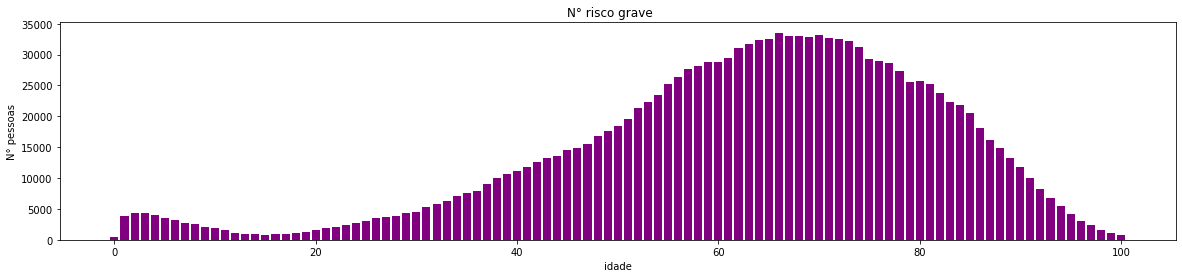

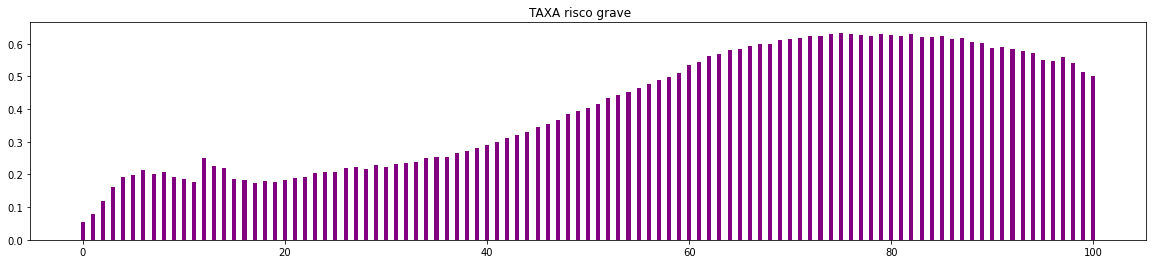

In [ ]:
df_risco_grave_por_idade    , df_sem_risco_por_idade_taxa = plot_por_idade(df[df["FATOR_RISC_GRAVE"] == 1]    , Npessoas_idade,taxa = True, titulo = "risco grave    ", titulo_taxa = "risco grave    ",color = 'purple')

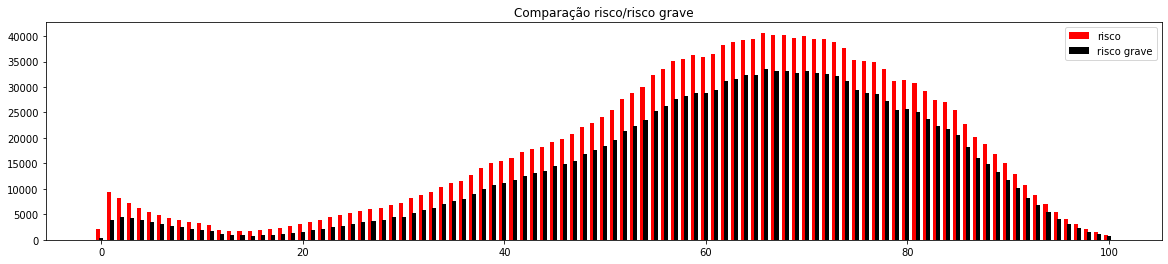

In [ ]:
multi_plot([df_risco_por_idade, df_risco_grave_por_idade   ], Npessoas_idade,titulo = "Comparação risco/risco grave", labels=["risco","risco grave"] ,colors = ["red","black"])


##Analise das mortes a partir da idade e fator de risco

Média de idade: 67.91
Desvio padrão da idade: 15.93
idades dentro de 1 desvio padrão:   [51.98, 83.84]
idades dentro de 2 desvios padrões: [36.05, 99.77]


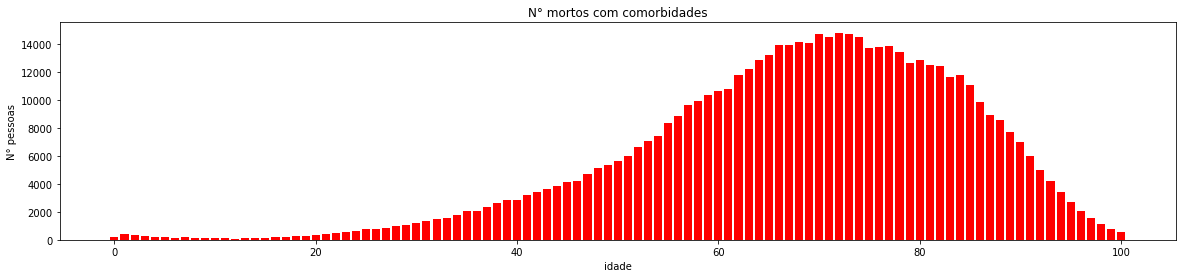

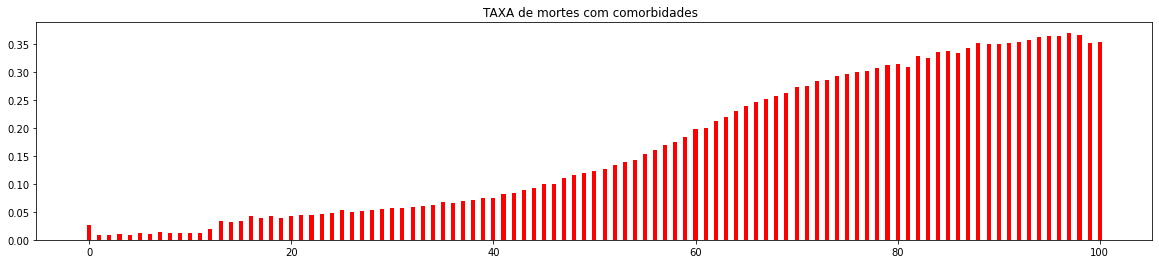




Média de idade: 63.02
Desvio padrão da idade: 18.03
idades dentro de 1 desvio padrão:   [44.99, 81.05000000000001]
idades dentro de 2 desvios padrões: [26.96, 99.08000000000001]


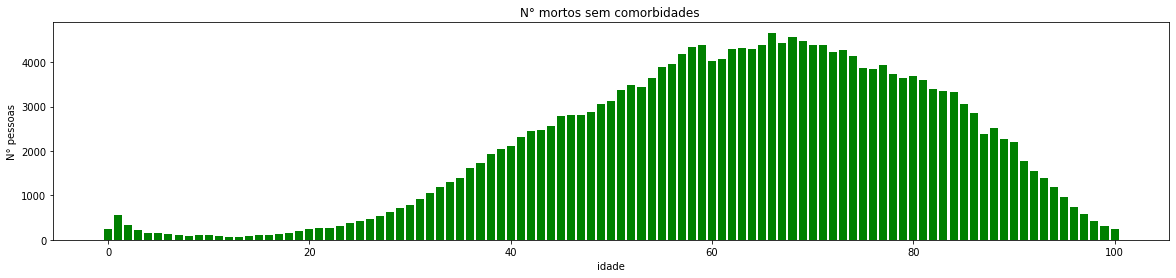

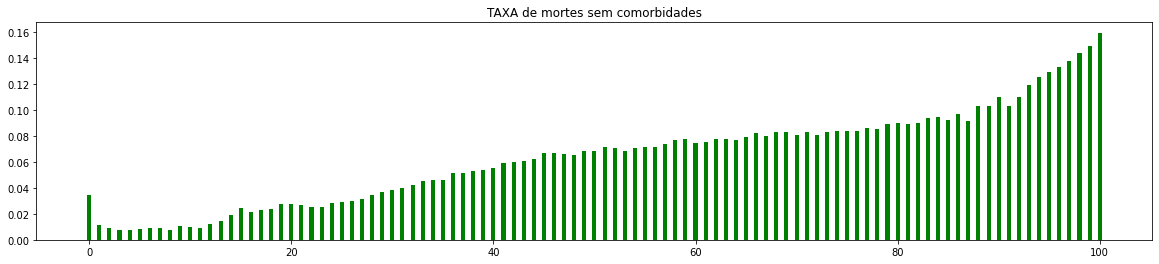




559481 mortos
30.88 % dos registros nessa base (pessoas com comorbidades) foram morreram
94.63 % mortos tem mais de 40 anos


In [ ]:
df_risco_mortos     = df_risco[df_risco["EVOLUCAO"] == 2]
df_sem_risco_mortos = df_sem_risco[df_sem_risco["EVOLUCAO"] == 2]


df_risco_mortos_por_idade    ,df_risco_mortos_por_idade_taxa     = plot_por_idade(df_risco_mortos    ,Npessoas_idade, titulo = "mortos com comorbidades", titulo_taxa = "de mortes com comorbidades  ",color = 'red')
df_sem_risco_mortos_por_idade,df_sem_risco_mortos_por_idade_taxa = plot_por_idade(df_sem_risco_mortos,Npessoas_idade, titulo = "mortos sem comorbidades ",titulo_taxa = "de mortes sem comorbidades",color = 'green')



N_mortos = df_risco_mortos.shape[0]
print(N_mortos,"mortos")
print(round(100*N_mortos/df_risco.shape[0],2),"% dos registros nessa base (pessoas com comorbidades) foram morreram")
print(
    round(
        100*df_risco_mortos_por_idade[40:].sum()[0]/N_mortos,
        2),
      "% mortos tem mais de 40 anos"
     )


# Idade como um fator de risco

Iremos usar a metrica por 10.000 pacientes para definir a taxa de mortos por idade,perceba pelo gráfico que o a taxa é maior que 1 acima de 60 anos, note que quanto mais velho maior o numero de casos e por fusão de um organismo mais debilitado temos uma taxa de mortes mais elevada. 

In [ ]:
df["COMORBIDADES"]        = df["FATOR_RISC"]
df["COMORBIDADE_GRAVE"] = df["FATOR_RISC_GRAVE"]
df.FATOR_RISC       = 1.0*(df["NU_IDADE_N"] >=60) + df["FATOR_RISC"]*(df["NU_IDADE_N"] < 60)
df.FATOR_RISC_GRAVE = 1.0*(df["NU_IDADE_N"] >=60) + df["FATOR_RISC_GRAVE"]*(df["NU_IDADE_N"] < 60)

Média de idade: 61.3
Desvio padrão da idade: 19.86
idades dentro de 1 desvio padrão:   [41.44, 81.16]
idades dentro de 2 desvios padrões: [21.58, 101.02]


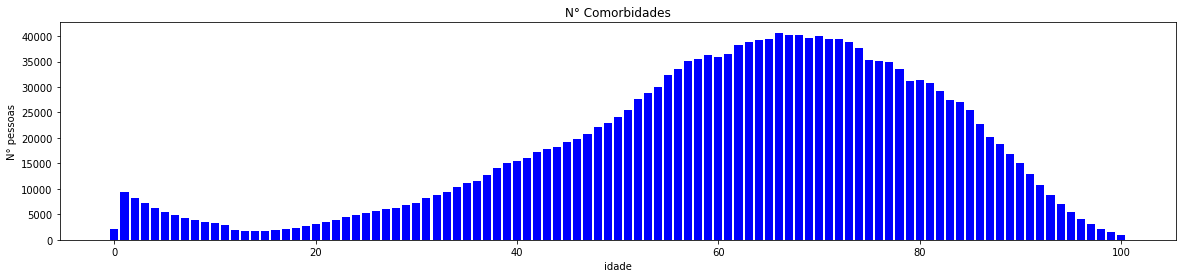

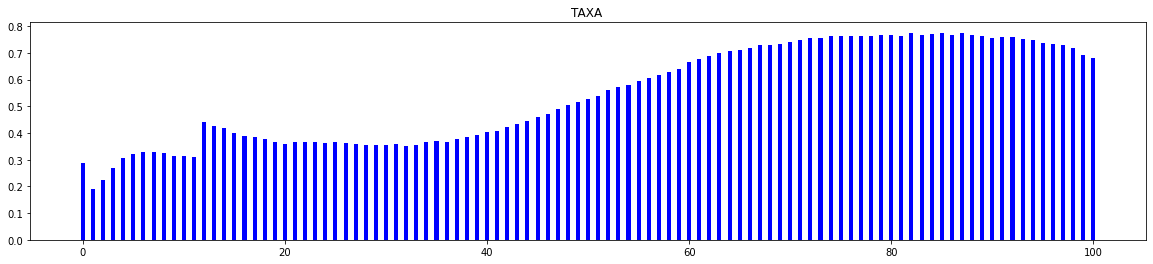




Média de idade: 63.31
Desvio padrão da idade: 19.04
idades dentro de 1 desvio padrão:   [44.27, 82.35]
idades dentro de 2 desvios padrões: [25.230000000000004, 101.39]


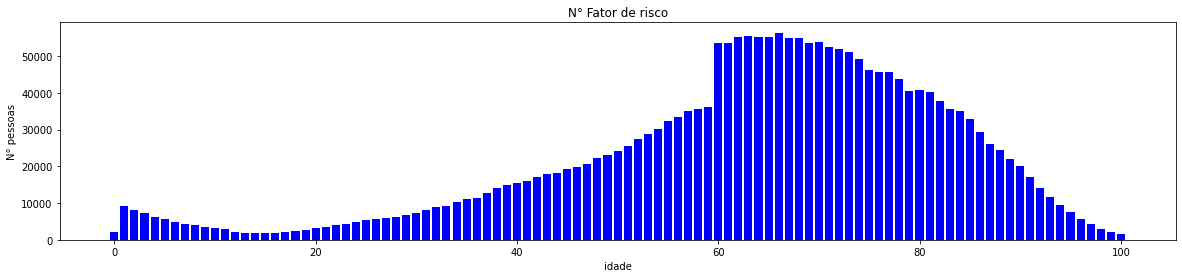

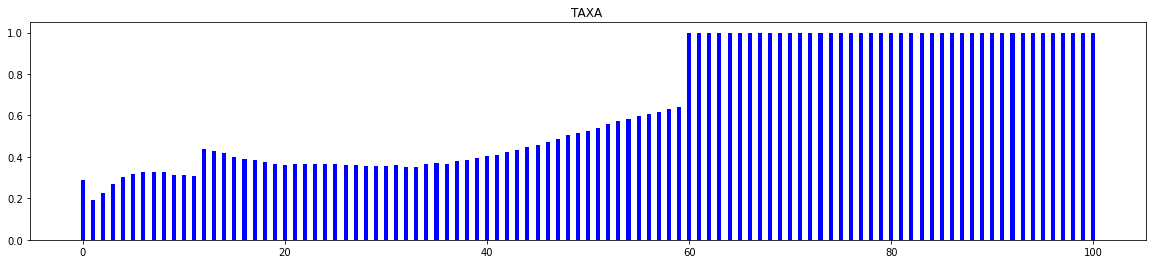

In [ ]:
df_comorbidade_por_idade,df_comorbidade_por_idade_taxa = plot_por_idade(df[df["COMORBIDADES"] == 1],Npessoas_idade,"Comorbidades")
df_fator_risco_por_idade,df_fator_risco_por_idade_taxa = plot_por_idade(df[df["FATOR_RISC"] == 1],Npessoas_idade,"Fator de risco")


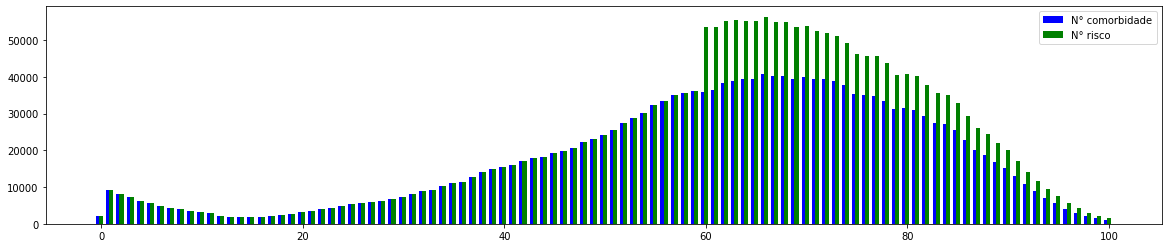

In [ ]:
multi_plot([
            df_comorbidade_por_idade,
            df_fator_risco_por_idade,
            ],
           Npessoas_idade,labels = ['N° comorbidade',"N° risco"],colors = ['blue','green'])

# Vacina

sabemos que recem-nascidos não podem receber logo a nascença a vacina para covid 

In [ ]:
vacina_no_nascimento = df.index[(df['DOSE_1_COV'] == df['DT_NASC'])]
print(f'Pessoas que tomaram a primeira dose logo a nascença: {len(vacina_no_nascimento)}') # foi detectada duas pessoas que tomaram a primiera dose assim que nasceram
vacina_no_nascimento_segunda_dose = df.index[(df['DOSE_2_COV'] == df['DT_NASC'])]
print(f'Pessoas que tomaram a segunda dose logo a nascença: {len(vacina_no_nascimento_segunda_dose)}') # foi detectada três pessoas que tomaram a segunda dose assim que nasceram 

Pessoas que tomaram a primeira dose logo a nascença: 1
Pessoas que tomaram a segunda dose logo a nascença: 0


Função usada com o objetivo de fornecer a quantidade de vacinados por idade!

## Pessoas vacinadas ordenas por idade,isso será util para sabermos:

1º taxa de vacinação por idade 

2º taxa de pessoas que foram vacinadas por idade e que foram para UTI

...


Média de idade: 65.02
Desvio padrão da idade: 18.27
idades dentro de 1 desvio padrão:   [46.75, 83.28999999999999]
idades dentro de 2 desvios padrões: [28.479999999999997, 101.56]


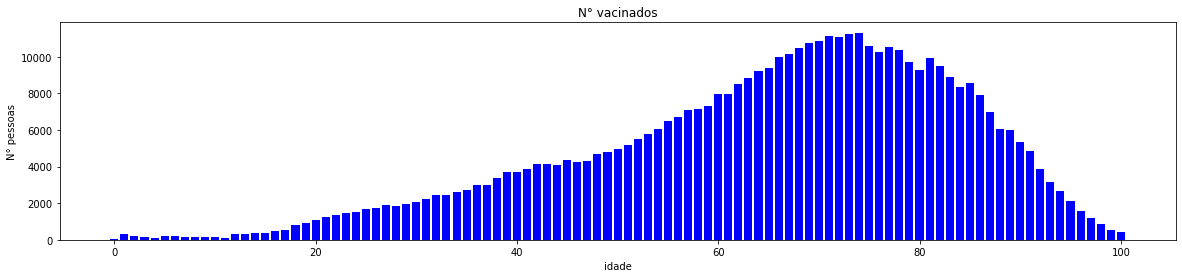

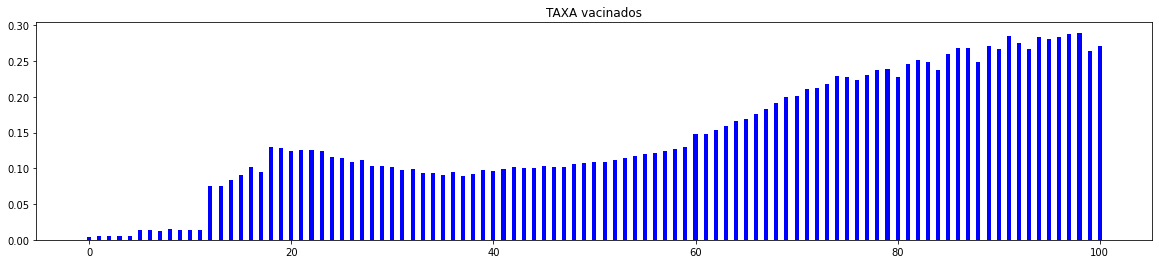

In [ ]:
df_vacinados = df[df["VACINA_COV"] == 1]
Npessoas_vacinadas_por_idade, vacinados_por_idade_taxa = plot_por_idade(df_vacinados,Npessoas_idade,titulo = "vacinados", titulo_taxa = "vacinados")

### analise de mortos e vacinados

In [ ]:
df_vacinados_mortos = df_vacinados[df_vacinados["EVOLUCAO"] == 2]

In [ ]:
df_pos_vacina = df[df["DT_SIN_PRI"] > pd.to_datetime("26/01/2021",dayfirst = 1)]
print("_"*100)
print("contando a partir do primeiro dia de vacinação\n\n")
for mes in range(2,10):
    print("MES:",mes)

    N_mortos_depois_vac = df_pos_vacina[df_pos_vacina["EVOLUCAO"] == 2][df_pos_vacina["DT_SIN_PRI"] <= pd.to_datetime("26/0"+str(mes)+"/2021",dayfirst = 1)].shape[0]
    N_vac_mortos = df_pos_vacina[df_pos_vacina["EVOLUCAO"] == 2][df_pos_vacina["DT_SIN_PRI"] <= pd.to_datetime("26/0"+str(mes)+"/2021",dayfirst = 1)][df_pos_vacina["DOSE_1_COV"] < pd.to_datetime("26/0"+str(mes)+  "/2021",dayfirst = 1)].shape[0]
    
    N_n_vac = df_pos_vacina[df_pos_vacina["DT_SIN_PRI"] <= pd.to_datetime("26/0"+str(mes)+"/2021",dayfirst = 1)][df_pos_vacina["VACINA_COV"]==2].shape[0]
    N_vac = df_pos_vacina[df_pos_vacina["DOSE_1_COV"] < pd.to_datetime("26/0"+str(mes)+  "/2021",dayfirst = 1)][df_pos_vacina["DT_SIN_PRI"] <= pd.to_datetime("26/0"+str(mes)+"/2021",dayfirst = 1)].shape[0]
    N_n_vac_mortos = df_pos_vacina[df_pos_vacina["DOSE_1_COV"] < pd.to_datetime("26/0"+str(mes)+  "/2021",dayfirst = 1)][df_pos_vacina["DT_SIN_PRI"] <= pd.to_datetime("26/0"+str(mes)+"/2021",dayfirst = 1)][df_pos_vacina["EVOLUCAO"]== 2].shape[0]

    print("porcentagem de vacinados que morreram: ",round(100*N_vac_mortos/N_vac,2),"%")
    print("porcentagem de mortos que eram vacinados: ",round(100*N_vac_mortos/N_mortos_depois_vac,2),"%")
    print("porcentagem de vacinados:",round(100*N_vac/df_pos_vacina.shape[0],2),"%")
    
    print("porcentagem de n vacinados que morreram: ",round(100*N_n_vac_mortos/N_n_vac,2),"%")
    print("porcentagem de mortos que n eram vacinados: ",round(100*N_n_vac_mortos/N_mortos_depois_vac,2),"%")
    print("porcentagem de n vacinados:",round(100*N_n_vac/df_pos_vacina.shape[0],2),"%")
    

    print("_"*100)

____________________________________________________________________________________________________
contando a partir do primeiro dia de vacinação


MES: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


porcentagem de vacinados que morreram:  46.35 %
porcentagem de mortos que eram vacinados:  2.39 %
porcentagem de vacinados: 0.16 %
porcentagem de n vacinados que morreram:  4.34 %
porcentagem de mortos que n eram vacinados:  2.39 %
porcentagem de n vacinados: 1.66 %
____________________________________________________________________________________________________
MES: 3
porcentagem de vacinados que morreram:  50.89 %
porcentagem de mortos que eram vacinados:  5.4 %
porcentagem de vacinados: 0.9 %
porcentagem de n vacinados que morreram:  6.28 %
porcentagem de mortos que n eram vacinados:  5.4 %
porcentagem de n vacinados: 7.25 %
____________________________________________________________________________________________________
MES: 4
porcentagem de vacinados que morreram:  43.31 %
porcentagem de mortos que eram vacinados:  8.79 %
porcentagem de vacinados: 2.48 %
porcentagem de n vacinados que morreram:  8.28 %
porcentagem de mortos que n eram vacinados:  8.79 %
porcentagem de n vaci

Média de idade: 65.05
Desvio padrão da idade: 18.28
idades dentro de 1 desvio padrão:   [46.769999999999996, 83.33]
idades dentro de 2 desvios padrões: [28.489999999999995, 101.61]


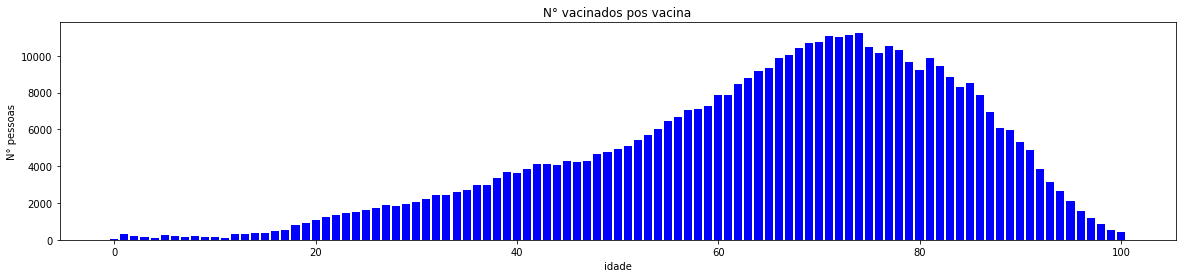

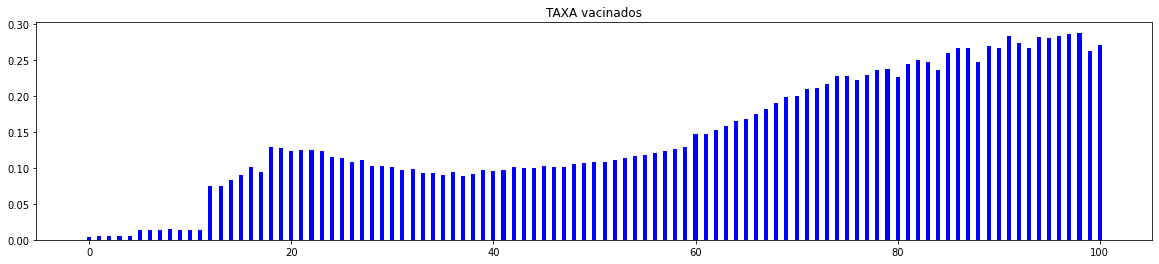

(            N_pessoas
 NU_IDADE_N           
 0                  27
 1                 291
 2                 215
 3                 147
 4                 122
 ...               ...
 96               1588
 97               1193
 98                864
 99                557
 100               409
 
 [101 rows x 1 columns],             N_pessoas
 NU_IDADE_N           
 0            0.003737
 1            0.005944
 2            0.005842
 3            0.005514
 4            0.005901
 ...               ...
 96           0.282663
 97           0.286023
 98           0.287712
 99           0.262488
 100          0.271040
 
 [101 rows x 1 columns])

In [ ]:
plot_por_idade(df_pos_vacina[df_pos_vacina["VACINA_COV"] == 1],Npessoas_idade,titulo = "vacinados pos vacina", titulo_taxa = "vacinados")

Média de idade: 72.87
Desvio padrão da idade: 14.11
idades dentro de 1 desvio padrão:   [58.760000000000005, 86.98]
idades dentro de 2 desvios padrões: [44.650000000000006, 101.09]


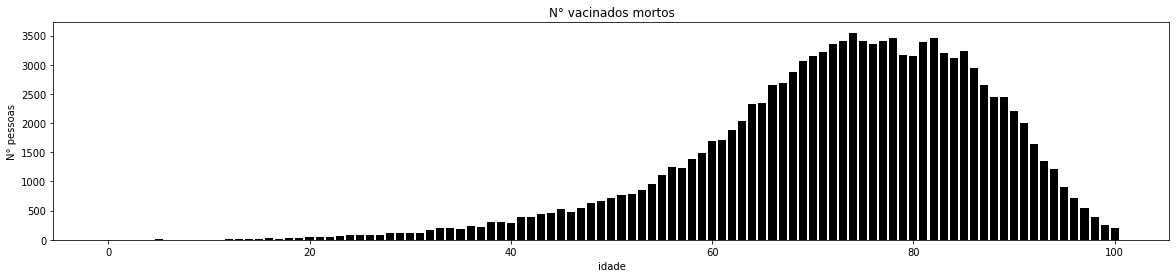

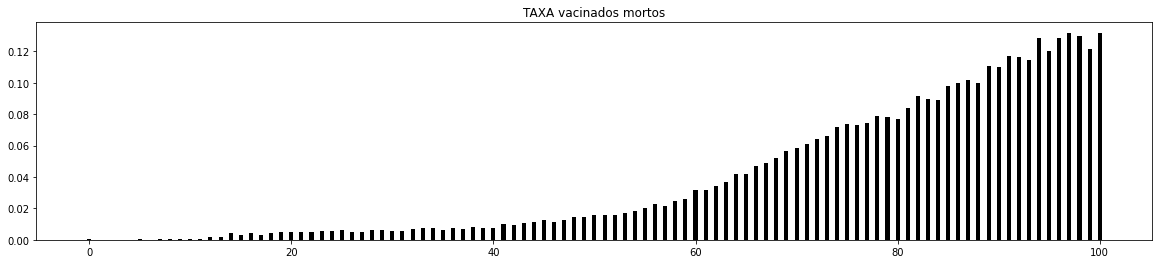

In [ ]:
df_vac_mort_por_idade,_ = plot_por_idade(df_vacinados[df_vacinados["EVOLUCAO"] ==2],Npessoas_idade,titulo = "vacinados mortos", titulo_taxa = "vacinados mortos",color = 'black')

In [ ]:
pd.merge(
    df_vac_mort_por_idade,
    Npessoas_vacinadas_por_idade,
    on = "NU_IDADE_N"
    ).rename(columns = {"N_pessoas_x": "N_vacinados_mortos","N_pessoas_y": "N_vacinados"})

,N_vacinados_mortos,N_vacinados
NU_IDADE_N,,
0,4,27
1,3,293
2,2,215
3,1,147
5,6,234
...,...,...
96,721,1592
97,548,1198
98,389,870


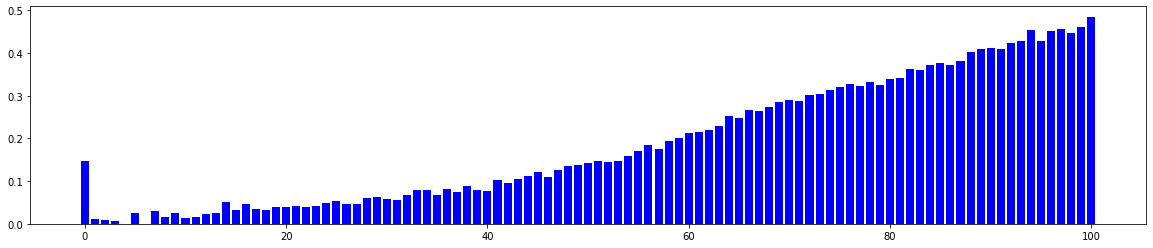

In [ ]:
grafico_barra((df_vac_mort_por_idade/Npessoas_vacinadas_por_idade).N_pessoas)

### análise de vacinados e não vacinados

In [ ]:
df_pos_vacina = df[df["DT_SIN_PRI"] > pd.to_datetime("31/01/2021",dayfirst = 1)]

In [ ]:
Npessoas_idade_pos_vacina_nao = df_pos_vacina[df_pos_vacina["VACINA_COV"]== 2][["NU_IDADE_N","DT_NOTIFIC"]].groupby(by = "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})
Npessoas_idade_pos_vacina     = df_pos_vacina[df_pos_vacina["VACINA_COV"]== 1][["NU_IDADE_N","DT_NOTIFIC"]].groupby(by = "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})


#### Mortes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


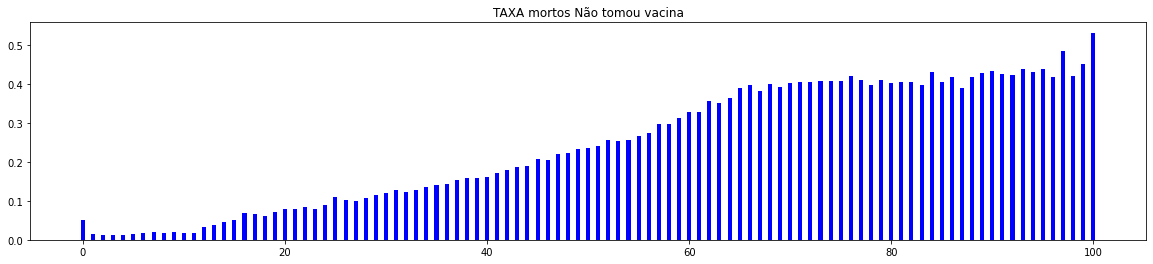

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


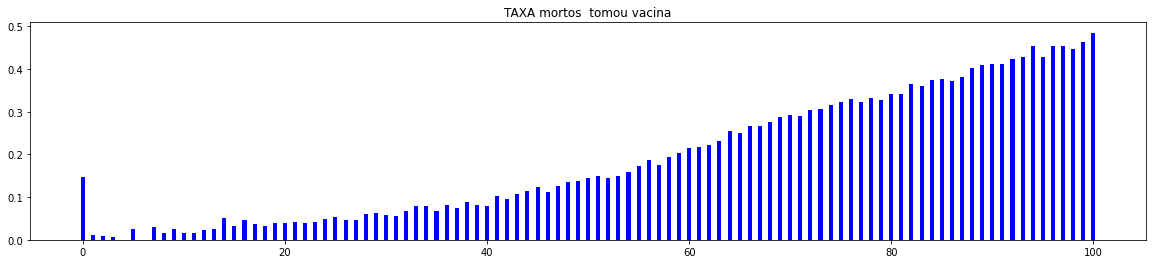

In [ ]:
plot_por_idade(df_pos_vacina[df_pos_vacina["VACINA_COV"]== 2][df_pos_vacina["EVOLUCAO"]== 2],Npessoas_idade_pos_vacina_nao,return_distributions=0,titulo_taxa = "mortos Não tomou vacina",contagem = 0)
plot_por_idade(df_pos_vacina[df_pos_vacina["VACINA_COV"]== 1][df_pos_vacina["EVOLUCAO"]== 2],Npessoas_idade_pos_vacina    ,return_distributions=0,titulo_taxa = "mortos  tomou vacina"   ,contagem = 0)

#### UTI

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


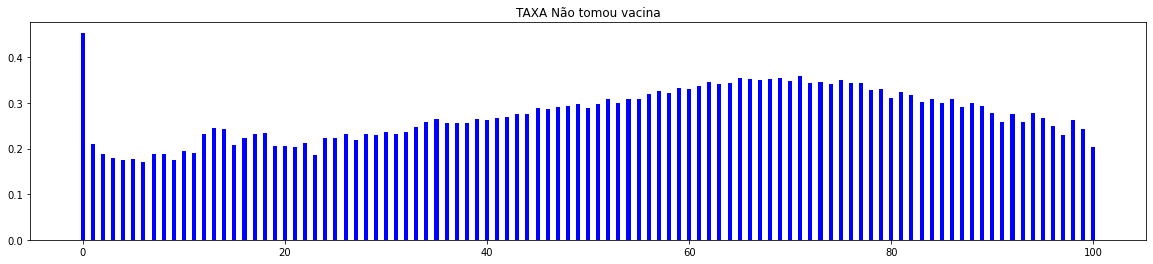

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


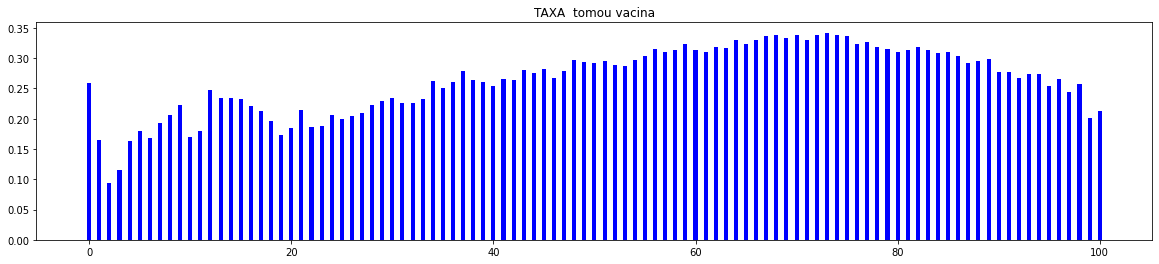

In [ ]:
Npessoas_idade_pos_vacina_nao = df_pos_vacina[df_pos_vacina["VACINA_COV"]== 2][["NU_IDADE_N","DT_NOTIFIC"]].groupby(by = "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})
Npessoas_idade_pos_vacina     = df_pos_vacina[df_pos_vacina["VACINA_COV"]== 1][["NU_IDADE_N","DT_NOTIFIC"]].groupby(by = "NU_IDADE_N").count().rename(columns = {"DT_NOTIFIC": "N_pessoas"})
plot_por_idade(df_pos_vacina[df_pos_vacina["VACINA_COV"]== 2][df_pos_vacina["UTI"]== 1],Npessoas_idade_pos_vacina_nao,return_distributions=0,titulo = "Não tomou vacina",titulo_taxa = "Não tomou vacina",contagem = False)
plot_por_idade(df_pos_vacina[df_pos_vacina["VACINA_COV"]== 1][df_pos_vacina["UTI"]== 1],Npessoas_idade_pos_vacina,return_distributions=0,titulo = "tomou vacina"    ,titulo_taxa = " tomou vacina",contagem = 0)

## Deletando

In [ ]:
del Npessoas_idade_pos_vacina_nao
del Npessoas_idade_pos_vacina    
del df_pos_vacina

## última vez que tomou vacina

In [ ]:
pd.to_datetime("01/02/2020",dayfirst = True) - pd.to_datetime("01/01/2020",dayfirst = True)

Timedelta('31 days 00:00:00')

df.ULT_DOSE = max(df.DOSE_1_COV, df.DOSE_2_COV, df.DOSE_REF)

In [ ]:
df["ULT_DOSE"] = np.where(pd.isnull(df.DOSE_2_COV) == False ,df.DOSE_2_COV,df.DOSE_1_COV)
df["ULT_DOSE"] = np.where(pd.isnull( df.DOSE_REF ) == False , df.DOSE_REF , df.ULT_DOSE )
df[["ULT_DOSE","DOSE_1_COV","DOSE_2_COV","DOSE_REF"]]

,ULT_DOSE,DOSE_1_COV,DOSE_2_COV,DOSE_REF
0,NaT,NaT,NaT,NaT
2,NaT,NaT,NaT,NaT
3,NaT,NaT,NaT,NaT
4,NaT,NaT,NaT,NaT
5,NaT,NaT,NaT,NaT
...,...,...,...,...
3107768,2021-10-11,2021-07-19,2021-10-11,NaT
3107769,NaT,NaT,NaT,NaT
3107770,2021-11-24,2021-03-05,2021-06-02,2021-11-24
3107771,2021-04-23,2021-03-04,2021-04-23,NaT


In [ ]:
df["TEMP_ULT_DOSE"] = np.where(   df.DT_SIN_PRI >= df.DOSE_REF                                     , df.DT_SIN_PRI - df.DOSE_REF  ,    pd.to_datetime(  np.NaN  )    )
df["TEMP_ULT_DOSE"] = np.where(  (df.DT_SIN_PRI >= df.DOSE_2_COV) & ( pd.isnull(df.TEMP_ULT_DOSE) ), df.DT_SIN_PRI - df.DOSE_2_COV, df.TEMP_ULT_DOSE )
df["TEMP_ULT_DOSE"] = np.where(  (df.DT_SIN_PRI >= df.DOSE_1_COV) & ( pd.isnull(df.TEMP_ULT_DOSE) ), df.DT_SIN_PRI - df.DOSE_1_COV, df.TEMP_ULT_DOSE )   

In [ ]:
df.TEMP_ULT_DOSE = df.TEMP_ULT_DOSE/ 100000000000

In [ ]:
((df.DT_SIN_PRI - df.DOSE_REF).dt.days >= 850).any()

False

In [ ]:
df[["TEMP_ULT_DOSE","ULT_DOSE","DT_SIN_PRI","DOSE_1_COV","DOSE_2_COV","DOSE_REF"]]

,TEMP_ULT_DOSE,ULT_DOSE,DT_SIN_PRI,DOSE_1_COV,DOSE_2_COV,DOSE_REF
0,NaN,NaT,2020-01-07,NaT,NaT,NaT
2,NaN,NaT,2020-02-08,NaT,NaT,NaT
3,NaN,NaT,2020-01-26,NaT,NaT,NaT
4,NaN,NaT,2020-01-10,NaT,NaT,NaT
5,NaN,NaT,2020-02-24,NaT,NaT,NaT
...,...,...,...,...,...,...
3107768,10368000000000000,2021-10-11,2022-02-08,2021-07-19,2021-10-11,NaT
3107769,NaT,NaT,2022-02-15,NaT,NaT,NaT
3107770,7344000000000000,2021-11-24,2022-02-17,2021-03-05,2021-06-02,2021-11-24
3107771,25142400000000000,2021-04-23,2022-02-08,2021-03-04,2021-04-23,NaT


## Primeiros sintomas antes da última dose

é possível:  df.DT_SIN_PRI < df.ULT_DOSE 

Basta que ele tenha tomado depois dos sintomas começarem.

Neste caso substitua pela última dose antes dos primeiros sintomas

In [ ]:
print(len(df[df.DT_SIN_PRI <= df.ULT_DOSE]))

56883


## Vacina gripe

In [ ]:
df["VACINA"].unique()

array([ 2.,  9., nan,  1.])

In [ ]:
df["VACINA"] = np.where(pd.isnull(df.VACINA),9,df.VACINA)

In [ ]:
df.VACINA = np.where((df["VACINA"] != 1) & (pd.isnull(df.DT_UT_DOSE) == False),1,df["VACINA"])

# Criar df a ser classificado com CLASSI_FIN  EVOLUCAO preenchidos com

mais de um terço das classificações finais foram ignorados ou NaN.
Podemos tirar para depois reclassificar

In [ ]:
df["CLASSI_FIN"].unique()

array([ 2.,  4., nan,  1.,  5.,  3.])

In [ ]:
len(df["CLASSI_FIN"][(pd.isnull(df["CLASSI_FIN"])) | (df["CLASSI_FIN"] == 4)  ])/len(df["CLASSI_FIN"])

0.3375094304372674

14,4% das evoluções foram ignorados ou NaN. Podemos tirar para depois reclassificar

In [ ]:
df["EVOLUCAO"].unique()

array([1., 2., 9., 3.])

In [ ]:
len(df["EVOLUCAO"][ df["EVOLUCAO"] == 9 ])/len(df["EVOLUCAO"])

0.14406659267192587

cerca de 40% possui uma das duas propriedades acima

In [ ]:
df [ (df["EVOLUCAO"] == 9 ) | (pd.isnull(df["CLASSI_FIN"])) | (df["CLASSI_FIN"] == 4)  ].shape[0]/len(df)

0.3902426841538165

In [ ]:
df_a_ser_classificado = df [ (df["EVOLUCAO"] == 9 ) | (pd.isnull(df["CLASSI_FIN"])) | (df["CLASSI_FIN"] == 4)  ]
df.drop(df_a_ser_classificado.index,inplace = True)

# Classificação de covid por exame

In [ ]:
df[ (df["TOMO_RES"] == 1) | (df["RES_IGM"] == 1) ][df["RES_AN"] == 1][((df["PCR_RESUL"] == 1) & (df["PCR_SARS2"] == 1))]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,ANO_DT_SIN_PRI,DIA_PRI,DIA_NOT,ONDA,OBES_MORB,FATOR_RISC_GRAVE,COMORBIDADES,COMORBIDADE_GRAVE,ULT_DOSE,TEMP_ULT_DOSE
1580,69,1.0,1.0,2.0,2.0,1.0,2.0,2.0,NaN,2,...,2020,181,195,1.000000,9.0,1.0,1,1.0,NaT,NaN
1922,84,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,2,...,2020,194,207,1.000000,9.0,1.0,1,1.0,NaT,NaN
2972,88,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,2,...,2020,276,289,1.159091,9.0,1.0,1,1.0,NaT,NaN
3144,29,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,2,...,2020,282,286,1.295455,9.0,1.0,1,1.0,NaT,NaN
3839,73,1.0,2.0,2.0,2.0,1.0,2.0,2.0,NaN,2,...,2020,330,344,2.000000,9.0,1.0,1,1.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106997,70,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1,...,2022,752,758,5.000000,9.0,1.0,1,1.0,2021-04-09,247968.0
3107043,61,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1,...,2022,791,794,5.000000,9.0,1.0,1,1.0,2021-12-14,66528.0
3107411,85,1.0,1.0,2.0,2.0,1.0,2.0,2.0,NaN,1,...,2022,743,755,5.000000,9.0,1.0,1,1.0,2021-04-02,246240.0
3107606,76,1.0,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1,...,2022,763,778,5.000000,9.0,1.0,1,1.0,2021-10-27,83808.0


In [ ]:
df["CLASSI_COV_EXAME"] = np.where((df["TOMO_RES"] == 1) | (df["RES_IGM"] == 1) |( (df["PCR_RESUL"] == 1) & (df["PCR_SARS2"] == 1)) , True,False)

#Tabela de Erros


In [ ]:
df_erro = pd.DataFrame()
df_erro = df_erro.append(df_dt_erro      ,ignore_index =True)
df_erro = df_erro.append(df_quarta_idade ,ignore_index =True)
df_erro = df_erro.append(df_erro_IMC     ,ignore_index =True)
df_erro = df_erro.append(df_doses_janssen,ignore_index =True) #se rodar a celula de df_doses_janssen uma segunda vez acho que dá problema por cusa do drop
df_erro

,NU_IDADE_N,FATOR_RISC,CARDIOPATI,ASMA,PNEUMOPATI,DIABETES,IMUNODEPRE,OBESIDADE,OBES_IMC,VACINA_COV,...,SEM_PRI,ANO_DOSE_1_COV,ANO_DOSE_2_COV,ANO_DT_ENTUTI,ANO_DT_INTERNA,ANO_DT_NOTIFIC,ANO_DT_SIN_PRI,DIA_PRI,DIA_NOT,ONDA
0,64,1,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,...,27.0,8202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,11.0,2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50,1,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,...,12.0,1921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80,1,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,10.0,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85,1,1.0,9.0,9.0,9.0,9.0,9.0,NaN,1.0,...,32.0,8202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14960,91,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,3.0,2021,2021,NaN,2022,NaN,NaN,NaN,NaN,NaN
14961,89,1,1.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,...,6.0,2021,2021,NaN,2022,NaN,NaN,NaN,NaN,NaN
14962,61,1,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,8.0,2021,2021,NaN,2022,NaN,NaN,NaN,NaN,NaN
14963,86,1,2.0,2.0,2.0,1.0,2.0,2.0,NaN,1.0,...,5.0,2021,2021,NaN,2022,NaN,NaN,NaN,NaN,NaN


In [ ]:
del df_dt_erro      
del df_quarta_idade 
del df_erro_IMC     
del df_doses_janssen

#Apenas fazer download após limpeza

## Ultima checagem

In [ ]:
for col in df.columns:
    print("_"*100)
    print(df[col][pd.isnull(df[col])])

____________________________________________________________________________________________________
Series([], Name: NU_IDADE_N, dtype: int64)
____________________________________________________________________________________________________
Series([], Name: FATOR_RISC, dtype: object)
____________________________________________________________________________________________________
Series([], Name: CARDIOPATI, dtype: float64)
____________________________________________________________________________________________________
Series([], Name: ASMA, dtype: float64)
____________________________________________________________________________________________________
Series([], Name: PNEUMOPATI, dtype: float64)
____________________________________________________________________________________________________
Series([], Name: DIABETES, dtype: float64)
____________________________________________________________________________________________________
Series([], Name: IMUNODEPRE, dtype

## Download

In [ ]:
df_a_ser_classificado.to_csv("sem_classe_base.csv", index = True)

In [ ]:
df.to_csv("full_base.csv", index = True)

In [ ]:
df_erro.to_csv("error_base.csv",index = True)